# Bottled Gazpacho Market Research 4 (0 - 4 scale)

I don't know about you, but I love Gazpacho. In Spain they sell those delicacies bottled in supermarkets. But what about the rest of the world? How sad I am eveytime I go to the supermarket and none of that elixir is available. Here's the wonderful sight that Spaniards take for granted, while everyone else can only dream of:

![gazpacho](./images/spanish_bottled_gazpacho.jpg)

No more! This stops here! Or so I hope. Let's perform some **simulated market research** to find out if there is a market for Gazpacho in the rest of the world.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe import config_manager
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler

from tinytroupe.validation import SimulationExperimentEmpiricalValidator, SimulationExperimentDataset, validate_simulation_experiment_empirically


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: c:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.5.1
Current date and time (local): 2025-07-22 23:36:42
Current date and time (UTC):   2025-07-23 02:36:42

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4.1-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 32000
temperature = 1.5
freq_penalty = 0.1
presence_penalty = 0.1
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_n

In [2]:
config_manager.update("action_generator_enable_quality_checks", True)
config_manager.update("action_generator_quality_threshold", 6)

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [3]:
control.begin("bottled_gazpacho_market_research_4b.cache.json")

2025-07-22 23:36:56,468 - tinytroupe - INFO - Cache file not found on path: bottled_gazpacho_market_research_4b.cache.json.


## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [4]:
target_nationality = "American"
population_size = 50

additional_demographic_specification = f"""
BESIDES other dimensions infered from the population demographic data (i.e., make sure those are still present), 
ensure these ADDITIONAL sampling dimensions are present, which must be as realistic as possible:
  - general attitude: from positive to negative, from optimistic to pessimistic, from open-minded to closed-minded
  - education: from the completely illiterate (can't even talk properly) to the highest scientist
  - culinary tastes: from traditional to modern, from spicy to mild, from vegetarian to meat-based
  - shopping habits: from frequent to occasional, from online to in-store, from frugal to extravagant
  - health consciousness: from health-focused to indulgent, from organic to conventional
  - attitude towards new products: from open-minded to skeptical, from adventurous to conservative
  - cultural influences: from local to global, from traditional to contemporary, from diverse to homogeneous
  - travel habits: from frequent travelers to homebodies, from local to international, from adventurous to cautious
  - cultural background: from diverse to homogeneous, from traditional to modern, from local to global
  - lifestyle: from active to sedentary, from urban to rural, from minimalist to extravagant

Each of these additional dimensions MUST have AT LEAST 10 values. 
For all of these, YOU MUST provide long, detailed sentences that describe the values in each dimension. NOT short
words. We need EACH value to be VERY detailed.

Make sure you also include EXTREME values so that we can properly capture even edge cases. We want a WIDE
range of different people and tastes!
"""
  

Should we also compute the other nationalities? This might take a while, so we leave it as an option.

In [5]:
compute_other_nationalities = True

Descriptions and standard questions for the survey.

In [6]:
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please present yourself and also list your top-10 interests?
    """

interviewer_main_question =\
    """ 
    Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with tomatoes, cucumbers, peppers, and olive oil. 
    We are considering offering it in supermarkets near you.

    Would you consider purchasing ready-to-drink bottled gazpacho if it was available at your local supermarket? How much do you like this idea? 

    Please rate your propensity of purchasing it (from 1 to 5), where:
       - 1: would NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
       - 2: very unlikely, but not impossible.
       - 3: maybe I would buy it, not sure.
       - 4: it is very likely.
       - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
    """

inner_monologue =\
    """
    I will be honest as I understand they are not here to judge me, but just to learn from me. 
    Such choices depend on many factors, but I will make my best guess, considering my current 
    situation in life, location, job and interests. I will not refrain from giving extreme answers, 
    such as 1 or 5, if that's how I really feel, as this exercise requires me to be honest, human and realistic.

    Now I **must** first THINK deeply about the question, consider all the factors that might influence my decision,
    and only then I will TALK with my response to the question as best, as detailed and as honestly as I can.
    """

Common mechaniss.

In [7]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product. A person rate his/her propensity from 1 (would NEVER buy) to 5 (would CERTAINLY buy it)." ,
                                     situation="Agent was asked to rate their interest in a bottled Gazpacho. They can respond with a propensity score from 1 (would NEVER buy) to 5 (would CERTAINLY buy it).", 
                                     fields=["name", "response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as '1', '2', '3', '4', '5' or 'N/A'(if there is no response or you cannot determine the precise response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [8]:
def is_there_a_good_market(df, positive_threshold=0.1, negative_threshold=0.5):
    # Convert responses to strings for consistent handling
    df_copy = df.copy()
    df_copy["response"] = df_copy["response"].astype(str)
    
    # Get counts and calculate percentages
    counts = df_copy["response"].value_counts()
    total = counts.sum()
    percentage = counts / total
    
    # Calculate percentages by rating category (using 1-5 scale)
    percentage_positive = percentage.get("4", 0) + percentage.get("5", 0)
    percentage_neutral = percentage.get("3", 0)
    percentage_negative = percentage.get("1", 0) + percentage.get("2", 0)
    percentage_na = percentage.get("N/A", 0)
    
    # Print the analysis
    print(f"Percentage of positive responses (4-5): {percentage_positive:.2%}")
    print(f"Percentage of neutral responses (3): {percentage_neutral:.2%}")
    print(f"Percentage of negative responses (1-2): {percentage_negative:.2%}")
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # also compute the mean and standard deviation of the responses
    df_copy["response"] = pd.to_numeric(df_copy["response"], errors='coerce')
    mean_response = df_copy["response"].mean()
    std_response = df_copy["response"].std()

    print(f"Mean response: {mean_response:.2f}")
    print(f"Standard deviation of responses: {std_response:.2f}")

    # Decision based on thresholds
    if percentage_positive > positive_threshold and percentage_negative < negative_threshold:
        print("VERDICT: There is a good market for bottled gazpacho.")
        return True
    else:
        print("VERDICT: There is not a good market for bottled gazpacho.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [9]:
factory = TinyPersonFactory.create_factory_from_demography("./information/populations/usa.json", 
                                                           population_size=population_size, 
                                                           additional_demographic_specification=additional_demographic_specification)

In [10]:
people = factory.generate_people(population_size, verbose=True)

2025-07-22 23:37:44,254 - tinytroupe - INFO - Sampling dimensions computed successfully.
2025-07-22 23:39:19,652 - tinytroupe - INFO - Sampling plan computed successfully.
2025-07-22 23:39:19,666 - tinytroupe - WARNING - Expected 50 samples, but got 46 samples. The LLM may have failed to sum up the quantities in the sampling plan correctly.
2025-07-22 23:39:19,667 - tinytroupe - INFO - Sample plan has been flattened, contains 46 total samples.
2025-07-22 23:40:10,738 - tinytroupe - INFO - Names generated for all samples in the sampling plan.
2025-07-22 23:40:10,751 - tinytroupe - INFO - Generating person with the following particularities: 
                    - Name, demographics and other characteristics:
                         {
    "age": [
        36,
        55
    ],
    "gender": [
        "Male"
    ],
    "racial_and_ethnic_composition": [
        "Hispanic or Latino"
    ],
    "educational_attainment": [
        "Some college or associate degree with vocational skills"
  

In [11]:
factory.sampling_dimensions

{'sampling_space_description': 'A comprehensive sampling space representing the diverse population of the United States of America, capturing detailed demographic, socioeconomic, cultural, personality, political, and lifestyle characteristics with proportions reflecting the latest demographic data and enriched with nuanced, detailed descriptive values for each dimension.',
 'dimensions': [{'name': 'age', 'range': [0, 100]},
  {'name': 'gender', 'values': {'Male': 0.492, 'Female': 0.508}},
  {'name': 'racial_and_ethnic_composition',
   'values': {'White (Non-Hispanic)': 0.571,
    'Hispanic or Latino': 0.194,
    'Black or African American': 0.121,
    'Asian': 0.07,
    'Two or More Races': 0.029,
    'American Indian or Alaska Native': 0.013,
    'Native Hawaiian or Pacific Islander': 0.002}},
  {'name': 'educational_attainment',
   'values': {'Completely illiterate, unable to speak properly or read basic texts': 0.1,
    'Basic literacy with limited reading and writing skills': 0.15,

In [12]:
factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Young urban White (Non-Hispanic) males with high education and middle to upper-middle income, open to new experiences and politically independent.',
  'sampled_values': {'age': [18, 35],
   'gender': ['Male'],
   'racial_and_ethnic_composition': ['White (Non-Hispanic)'],
   'educational_attainment': ["Bachelor's degree with specialized knowledge in a field",
    'Graduate or professional degree with advanced expertise and research experience'],
   'household_income': ['Middle income between $50,000 and $99,999',
    'Upper-middle income between $100,000 and $199,999'],
   'geographic_distribution': ['Urban residents living in densely populated metropolitan areas with access to diverse amenities and services'],
   'personality_traits': ['Individuals with high openness to experience, embracing new ideas and cultural diversity, often found in New York and California',
    'Highly conscientious individuals, diligent and organized, prevalent in Kan

We can request a specific number of people.

A quick look into the folks that were created:

In [13]:
factory.generated_minibios

['Calvin Theodore Ashford is a 29 year old Senior Data Scientist, American, currently living in Brooklyn, New York City, NY, USA. Beyond his professional expertise, Calvin is a thoughtful and introspective individual who values deep, meaningful conversations and intellectual curiosity. He enjoys exploring diverse cultures through travel and cuisine, often experimenting with fusion recipes at home. A moderate introvert, he prefers quality time with close friends and engaging in activities like attending jazz clubs, visiting museums, or hosting board game nights. His commitment to ethical data use and urban sustainability reflects a strong sense of social responsibility, which he also expresses through volunteering and writing about the intersection of technology and social impact.',
 'Mateo Alejandro Vargas Herrera is a 44 year old Registered Nurse and Community Health Worker, Mexican, currently living in Houston, Texas, USA. Mateo is a warm and conscientious individual who balances his

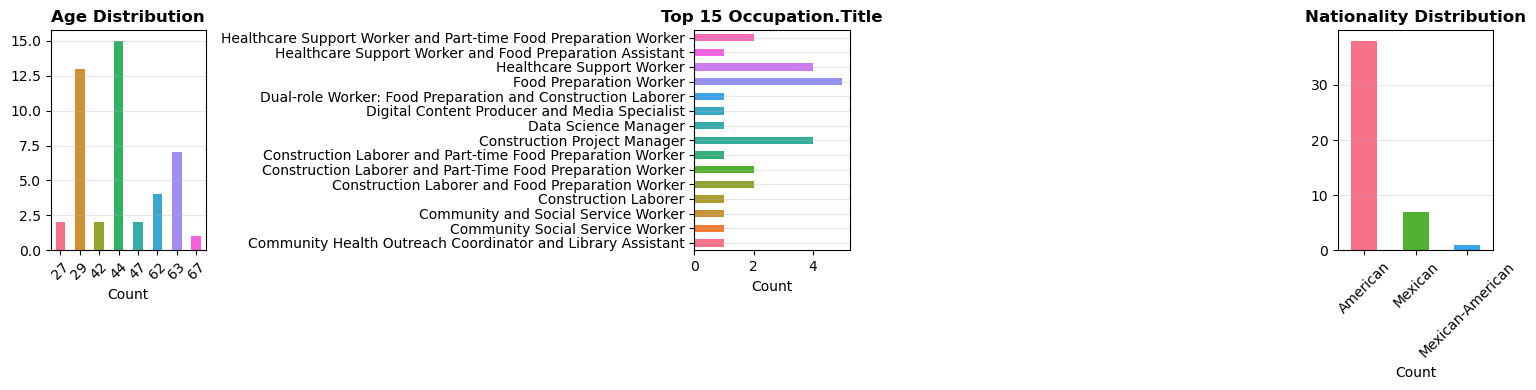

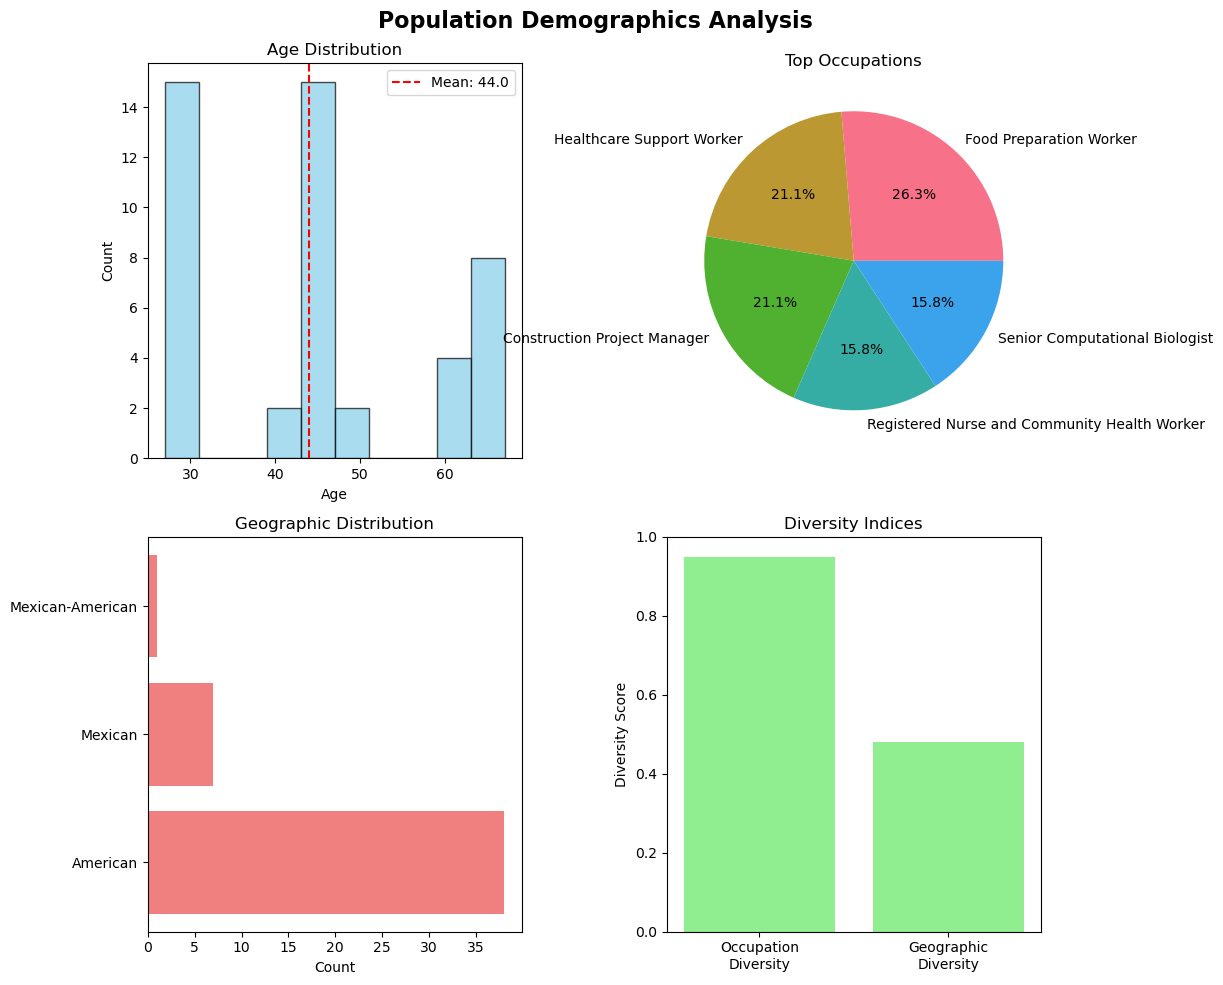

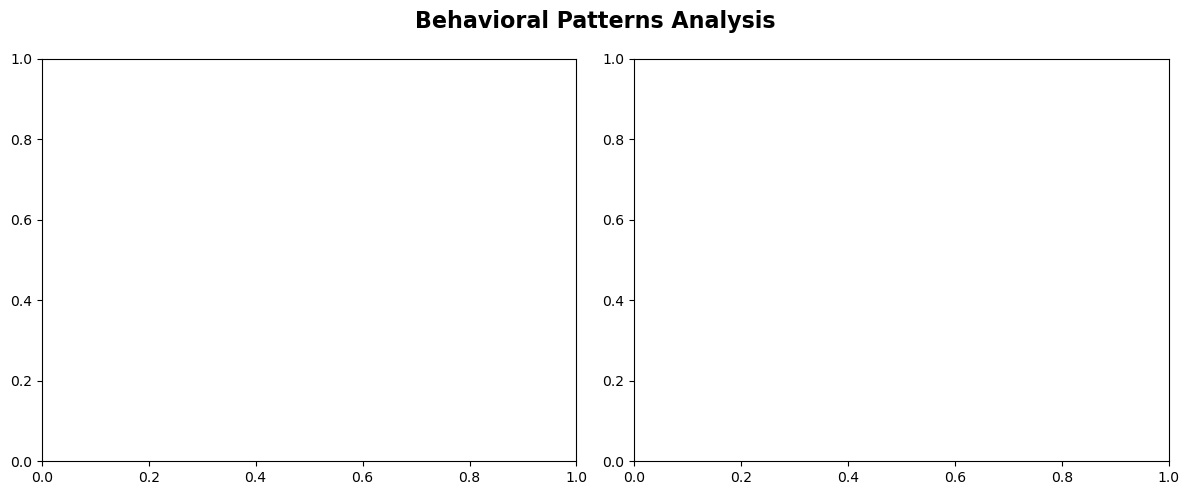

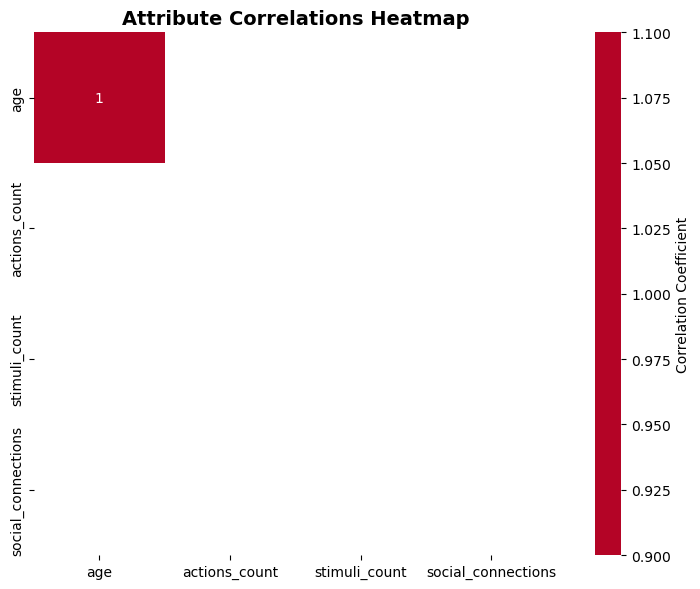

{'distributions': {'age': 27     2
  29    13
  42     2
  44    15
  47     2
  62     4
  63     7
  67     1
  Name: count, dtype: int64,
  'occupation.title': Community Health Outreach Coordinator and Library Assistant        1
  Community Social Service Worker                                    1
  Community and Social Service Worker                                1
  Construction Laborer                                               1
  Construction Laborer and Food Preparation Worker                   2
  Construction Laborer and Part-Time Food Preparation Worker         2
  Construction Laborer and Part-time Food Preparation Worker         1
  Construction Project Manager                                       4
  Data Science Manager                                               1
  Digital Content Producer and Media Specialist                      1
  Dual-role Worker: Food Preparation and Construction Laborer        1
  Food Preparation Worker                                 

In [14]:
profiler = Profiler()
profiler.profile(people)

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [15]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [16]:
market = TinyWorld(f"Target audience ({target_nationality})", people, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [17]:
market.broadcast(interviewer_introduction)
market.broadcast(interviewer_main_question)
market.broadcast_thought(inner_monologue)

USER --> Calvin Theodore Ashford: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> Mateo Alejandro Vargas Herrera

       + --> Ethan Marshall Granger

       + --> ...others...

USER --> Calvin Theodore Ashford: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 1 to 5), where:        - 1: would
          > NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how
          > you feel, as it is part of the human experience.        - 2: very unlikely, but not
          > impossible.        - 3: maybe I would buy it, not sure.        - 4: it is very likely.
          > - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive
          > answer if it is how you feel, as it is part of the human experience.

       + --> Mateo Alejandro Vargas Herrera

       + --> Ethan Marshall Granger

       + --> ...others...

Calvin Theodore Ashford --> Calvin Theodore Ashford: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Mateo Alejandro Vargas Herrera --> Mateo Alejandro Vargas Herrera: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Ethan Marshall Granger --> Ethan Marshall Granger: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Clarence Darnell Whitfield --> Clarence Darnell Whitfield: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Clara Meredith Hargrove --> Clara Meredith Hargrove: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Loretta Janice Freeman --> Loretta Janice Freeman: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Isabel Mariela Torres Delgado --> Isabel Mariela Torres Delgado: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Mabel Louise Cartwright --> Mabel Louise Cartwright: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Wesley Grant Carmichael --> Wesley Grant Carmichael: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Jordan Kai Navarro-Simms --> Jordan Kai Navarro-Simms: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Evelyn Margaret Hensley --> Evelyn Margaret Hensley: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Gideon Marshall Treadwell --> Gideon Marshall Treadwell: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Isabel Cristina Mendoza Rivera --> Isabel Cristina Mendoza Rivera: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Thomas Red Elk --> Thomas Red Elk: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.

Mildred Joyce Hargis --> Mildred Joyce Hargis: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Nalani Kealoha Makoa --> Nalani Kealoha Makoa: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Caroline Meredith Hargrove --> Caroline Meredith Hargrove: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Lucía Maribel Domínguez --> Lucía Maribel Domínguez: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Mariana Estela Rivas --> Mariana Estela Rivas: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Emilio Javier Salazar Ortega --> Emilio Javier Salazar Ortega: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Gloria Annette Jefferson --> Gloria Annette Jefferson: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Leroy Darnell McKnight --> Leroy Darnell McKnight: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Elliot Bradford Winslow --> Elliot Bradford Winslow: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Gideon Everett Langston --> Gideon Everett Langston: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Isabel Marisol Herrera --> Isabel Marisol Herrera: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Vivian Adelaide Carmichael --> Vivian Adelaide Carmichael: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Trenton Wade Calloway --> Trenton Wade Calloway: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Harold Darnell McCoy --> Harold Darnell McCoy: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Malcolm Jerome Tate --> Malcolm Jerome Tate: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Clara Bethany Winslow --> Clara Bethany Winslow: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Nisha Aria Takahashi --> Nisha Aria Takahashi: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Caleb Harrison Whitfield --> Caleb Harrison Whitfield: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Elijah Running Bear --> Elijah Running Bear: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Sahana Priya Desai --> Sahana Priya Desai: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.

Dorothy Mae Hensley --> Dorothy Mae Hensley: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Anika Mei-Ling Chen --> Anika Mei-Ling Chen: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Derek Franklin Caldwell --> Derek Franklin Caldwell: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Rafael Ignacio Morales Cruz --> Rafael Ignacio Morales Cruz: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Margaret Elaine Whitmore --> Margaret Elaine Whitmore: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Calvin Everett Hargrove --> Calvin Everett Hargrove: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Avery Simone Delgado --> Avery Simone Delgado: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Garrett Milton Prescott --> Garrett Milton Prescott: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Leilani Kahele --> Leilani Kahele: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.

Jaden Marcellus Vega --> Jaden Marcellus Vega: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Miriam Esther Goldfarb --> Miriam Esther Goldfarb: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Eleanor Rosenthal Katz --> Eleanor Rosenthal Katz: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

In [18]:
market.run(1)

2025-07-22 23:45:46,154 - tinytroupe - INFO - [Target audience (American)] Running world simulation step 1 of 1.


───────────────────────────────────── Target audience (American) step 1 of 1 ──────────────────────────────────────

2025-07-22 23:45:46,159 - tinytroupe - INFO - [Target audience (American)] No timedelta provided, so the datetime was not advanced.


Evelyn Margaret Hensley acts: [THINK] 
                             > Considering my lifestyle, dietary preferences, and the fact that I
                             > enjoy fresh, wholesome foods, I think about how gazpacho fits into my
                             > routine. I appreciate nutritious meals and often cook from scratch,
                             > but convenience is also important given my busy schedule. Gazpacho,
                             > being a cold vegetable soup, sounds refreshing and healthy,
                             > especially during warmer months. However, I am cautious about
                             > processed or pre-packaged foods and prefer natural ingredients. I
                             > must weigh these factors carefully before deciding how likely I would
                             > be to purchase ready-to-drink bottled gazpacho.

Clara Meredith Hargrove acts: [THINK] 
                             > I need to consider my lifestyle, preferences, and the practicality of
                             > buying ready-to-drink gazpacho. Given my interest in cooking and
                             > fresh ingredients, I usually prefer homemade meals, but convenience
                             > can be appealing on busy days. Gazpacho is not a common dish in my
                             > usual diet, but I appreciate healthy options and fresh vegetables. I
                             > should weigh how likely I am to purchase it regularly or
                             > occasionally, considering my health-conscious habits and dislike for
                             > highly processed foods.

Isabel Mariela Torres Delgado acts: [THINK] 
                                   > I need to consider my lifestyle, preferences, and cultural
                                   > background before answering about buying bottled gazpacho. I
                                   > usually prefer fresh, homemade foods, especially traditional
                                   > Mexican dishes. Gazpacho is not a common dish in my culture,
                                   > and I might find it unusual. However, if it were convenient and
                                   > tasty, I might consider trying it. I also have to think about
                                   > my budget and whether this product fits into it. Given these
                                   > factors, I think my propensity to buy would be moderate, maybe
                                   > a 3, because I'm open to trying new things but cautious about
                                   > spending on unfamiliar products.

Wesley Grant Carmichael acts: [THINK] 
                             > I need to consider my personal preferences, lifestyle, and typical
                             > food choices before answering about gazpacho. Given my preference for
                             > hearty American fare like grilled meats and barbecue, and my dislike
                             > for unfamiliar or exotic cuisines, I am skeptical about ready-to-
                             > drink gazpacho. Also, cold vegetable soups are not something I
                             > usually consume. However, I should be honest and rate my propensity
                             > realistically based on these factors.

Mateo Alejandro Vargas Herrera acts: [THINK] 
                                    > I need to consider my personal preferences, cultural
                                    > background, and lifestyle when deciding about purchasing
                                    > ready-to-drink bottled gazpacho. Gazpacho is a cold vegetable
                                    > soup from Spain, which is not a traditional dish in my Mexican
                                    > heritage, but I do appreciate fresh and healthy foods. I also
                                    > think about convenience since I have a busy schedule as a
                                    > nurse and community health worker. However, I prefer freshly
                                    > made foods and dislike processed foods. I should weigh these
                                    > factors carefully before giving my rating.

Clarence Darnell Whitfield acts: [THINK] 
                                > I reckon I gotta be honest 'bout this gazpacho thing. Ain't never
                                > had it before, and it sounds kinda fancy for around here. I like
                                > my food simple and warm, like fried catfish or collard greens.
                                > Bottled cold soup just don't sit right with me, but I gotta think
                                > if maybe folks 'round here might buy it. Still, I ain't much for
                                > newfangled stuff or things that ain't part of our tradition. So I
                                > gotta figure if I'd even consider buying it or not.

Ethan Marshall Granger acts: [THINK] 
                            > Alright, lemme think this through. Gazpacho's a cold veggie soup from
                            > Spain, right? Tomatoes, cucumbers, peppers, olive oil. Sounds kinda
                            > fancy for around here. I ain't used to cold soups much, especially
                            > bottled ones. I like hearty, warm meals, like burgers or stews. Plus,
                            > I ain't sure if I'd trust a ready-to-drink bottled soup from the
                            > store. But maybe on a hot day it could be alright. Still, I gotta be
                            > honest, I probably wouldn't buy it much. So, on that 1 to 5 scale, I'd
                            > say 2. Very unlikely, but not impossible if I was curious or it was
                            > cheap enough. Yeah, that sounds about right.

Calvin Theodore Ashford acts: [THINK] 
                             > Considering my lifestyle in Brooklyn, my interest in diverse
                             > cuisines, and my preference for authentic, fresh foods, I need to
                             > evaluate how a ready-to-drink bottled gazpacho fits into my habits.
                             > Gazpacho is a Spanish cold soup, which aligns with my appreciation
                             > for Mediterranean flavors. However, I usually prefer fresh or freshly
                             > prepared meals over processed or bottled options. Also, I dislike
                             > overly processed snacks and fast food, so that might influence my
                             > willingness to buy such a product. On the other hand, convenience is
                             > important given my busy schedule as a senior data scientist. I should
                             > weigh these factors carefully before giving a rating.

Mabel Louise Cartwright acts: [THINK] 
                             > I reckon I should think about this gazpacho thing real careful-like.
                             > It ain't somethin' folks 'round here usually drink, especially cold
                             > soups from faraway places like Spain. I like my food warm and home-
                             > cooked, like the biscuits and pies I bake. But I gotta be honest and
                             > consider if it might be handy or tasty enough to buy ready-made. I
                             > don't much care for fancy or unfamiliar foods, and I prefer simple,
                             > traditional meals. So, I might lean towards not buying it, but I
                             > gotta weigh if it could be useful on a hot day or for a quick meal.
                             > I'll think on this a bit more before I answer.

Loretta Janice Freeman acts: [THINK] 
                            > Alright, lemme think 'bout this gazpacho thing real careful-like. I
                            > ain't too familiar with it, but I know it's a cold soup from Spain
                            > made with veggies like tomatoes and cucumbers. Now, I usually prefer
                            > home-cooked meals, especially soul food, and I don't like processed or
                            > fast foods much. Also, cold foods ain't always my favorite, especially
                            > if they ain't familiar. But I do care 'bout healthy options and fresh
                            > veggies. Considering my cautious nature and preference for routine, I
                            > might be hesitant to try somethin' new like bottled gazpacho. On the
                            > other hand, if it's convenient and tastes good, maybe I'd consider it.
                            > So, I reckon my likelihood to buy it would be around a 2, very
                            > unlikely but not impossible. I gotta be honest 'bout my feelings here.

Gideon Marshall Treadwell acts: [THINK] 
                               > Alright, I gotta think this through. Gazpacho's a cold veggie soup
                               > from Spain, huh? Not really something I grew up with or usually
                               > eat. Around here, I prefer hearty, warm meals, especially with
                               > meat. Plus, I'm not big on fancy or unfamiliar foods. But I get
                               > that some folks might like it. Considering my tastes and habits,
                               > I'd probably be pretty unlikely to buy bottled gazpacho at the
                               > supermarket. Maybe a 2 on that scale. I don't wanna flat out say
                               > never, but it's just not my thing. Now I gotta put this into words
                               > and say it straight.

Jordan Kai Navarro-Simms acts: [THINK] 
                              > Alright, let's break this down. Gazpacho is a cold vegetable soup
                              > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I
                              > like fresh, authentic flavors and multicultural cuisines, so that
                              > fits my interests. But I also have a mild allergy to shellfish, so I
                              > have to be careful with new foods, though gazpacho doesn't have
                              > shellfish. I usually prefer fresh or homemade food over processed or
                              > bottled versions, but convenience sometimes wins out, especially
                              > with my busy freelance schedule. I also dislike overly
                              > commercialized or chain products lacking character, so the brand and
                              > quality would matter. Considering all this, I think I'd rate my
                              > propensity to buy ready-to-drink bottled gazpacho as a 3: maybe I'd
                              > buy it, not sure. It depends on the taste and authenticity, but I'm
                              > open to trying it.

Evelyn Margaret Hensley acts: [TALK] 
                             > Thank you for explaining about gazpacho. Considering my preference
                             > for fresh and wholesome foods, and my cautiousness about processed
                             > items, I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 3. I might buy it occasionally, especially during
                             > warmer months when a cold, refreshing soup sounds appealing, but I
                             > would want to check the ingredients to ensure it's made with natural,
                             > high-quality components.

Clara Meredith Hargrove acts: [TALK] 
                             > Thank you for explaining. Considering my preference for fresh,
                             > homemade meals and my general dislike for highly processed foods, I
                             > would rate my propensity to purchase ready-to-drink gazpacho as a 2.
                             > It's not impossible that I might try it occasionally, especially if
                             > it's made with quality ingredients and fits into a healthy diet, but
                             > I would be very unlikely to buy it regularly.

Wesley Grant Carmichael acts: [TALK] 
                             > Honestly, I'd rate my propensity to buy ready-to-drink bottled
                             > gazpacho as a 1. I prefer hearty American foods like grilled meats
                             > and barbecue, and cold vegetable soups just aren't my thing. It seems
                             > a bit too unfamiliar and not really suited to my tastes or lifestyle.

Jordan Kai Navarro-Simms acts: [TALK] 
                              > Honestly, I'd say a 3. I mean, gazpacho sounds fresh and fits my
                              > love for multicultural cuisines, but I'm kinda picky about bottled
                              > stuff. If it's authentic and tastes good, maybe I'd grab it
                              > sometimes, but I usually prefer fresh or homemade. So yeah, maybe
                              > I'd buy it, not sure though.

Calvin Theodore Ashford acts: [TALK] 
                             > Given my appreciation for Mediterranean flavors and fresh foods, I
                             > would rate my propensity to purchase ready-to-drink bottled gazpacho
                             > as a 3. I might buy it occasionally, especially if it's made with
                             > high-quality, natural ingredients, but I generally prefer freshly
                             > prepared meals over bottled options. Convenience is a factor, but I
                             > remain somewhat cautious about processed products.

Mabel Louise Cartwright acts: [THINK] 
                             > I been thinkin' on that gazpacho question some more. I don't rightly
                             > like cold soups much, and it ain't part of our usual fare 'round
                             > here. I prefer warm, home-cooked meals, like the chicken and dumplins
                             > or a good pie. But I reckon on a hot summer day, it might be
                             > refreshing for some folks. Still, I ain't sure I'd buy it myself,
                             > 'cause it don't fit with what I like or what I usually eat. So, I
                             > figure my answer's gonna be low on the scale, maybe a 2, 'cause I
                             > can't say never, but it's mighty unlikely I'd buy it.

Mateo Alejandro Vargas Herrera acts: [TALK] 
                                    > I appreciate the idea of having ready-to-drink bottled
                                    > gazpacho available, especially since it's a healthy option.
                                    > However, I usually prefer freshly made foods and tend to avoid
                                    > processed items. Considering my busy schedule, convenience is
                                    > important, but I would rate my propensity to purchase it as a
                                    > 3 — maybe I would buy it, but I'm not sure yet.

Ethan Marshall Granger acts: [TALK] 
                            > Look, I gotta be straight with ya. I ain't much into that bottled
                            > gazpacho stuff. Cold veggie soup just ain't my thing, especially in a
                            > bottle. I'd probably give it a 2 on your scale—very unlikely to buy
                            > it, but I ain't sayin' never. Maybe if it was cheap or I was real
                            > curious, I'd try it once. But mostly, I stick to hearty, warm meals
                            > that fill me up after a long day of work. So yeah, not really sold on
                            > this idea.

Isabel Mariela Torres Delgado acts: [TALK] 
                                   > Thank you for explaining about gazpacho. Honestly, I think I
                                   > would rate my likelihood of buying ready-to-drink bottled
                                   > gazpacho as a 3. I like to try new foods sometimes, but since
                                   > gazpacho is not a traditional dish for me and I usually prefer
                                   > fresh, homemade meals, I'm a bit unsure. If it tastes good and
                                   > is convenient, I might buy it occasionally, but it wouldn't be
                                   > a regular purchase for me.

Wesley Grant Carmichael acts: [DONE] 

Jordan Kai Navarro-Simms acts: [DONE] 

Gideon Marshall Treadwell acts: [TALK] 
                               > Honestly, I ain't much into that gazpacho stuff. Cold veggie soup
                               > from Spain don't really fit my taste. I'd say maybe a 2 on buying
                               > it, real unlikely but not impossible. I prefer warm, hearty meals
                               > around here, so that bottled gazpacho just ain't my thing.

Loretta Janice Freeman acts: [TALK] 
                            > Well, I gotta be honest, I ain't too sure 'bout buyin' that bottled
                            > gazpacho. I usually like my food home-cooked, you know, like soul food
                            > from my mama's kitchen. Cold soups and new stuff like that kinda make
                            > me nervous. So, I'd say my chance of buyin' it is a 2 — very unlikely,
                            > but I ain't sayin' never. If it was tasty and healthy, maybe I'd give
                            > it a try, but I ain't countin' on it much.

Clarence Darnell Whitfield acts: [TALK] 
                                > Well, I gotta be straight with ya. I ain't never tried gazpacho
                                > before, and it sounds kinda fancy for folks 'round here. I like my
                                > food warm and simple, like fried catfish or collard greens.
                                > Bottled cold soup just don't sit right with me. So if I had to
                                > rate my likin' for buyin' it, I'd say a 1 — I wouldn't buy it, no
                                > sir. But I reckon some might give it a try, though it ain't for
                                > me.

Ethan Marshall Granger acts: [DONE] 

Gideon Marshall Treadwell acts: [DONE] 

Loretta Janice Freeman acts: [DONE] 

Clarence Darnell Whitfield acts: [DONE] 

Clara Meredith Hargrove acts: [THINK] 
                             > I have been asked to present myself and list my top-10 interests. I
                             > should introduce myself clearly and warmly, reflecting my
                             > professional roles and personal traits. Then, I will list my main
                             > interests, focusing on those that define me and align with my
                             > persona, such as reading, cooking, community involvement, and health
                             > education. I want to sound approachable and thoughtful, consistent
                             > with my style.

Mateo Alejandro Vargas Herrera acts: [TALK] 
                                    > Hola, soy Mateo Alejandro Vargas Herrera, tengo 44 años y
                                    > trabajo como enfermero registrado y trabajador de salud
                                    > comunitaria en el Houston Community Health Center. Me dedico
                                    > principalmente al cuidado ambulatorio, enfocándome en la
                                    > prevención y manejo de enfermedades crónicas en poblaciones
                                    > urbanas desatendidas. También soy voluntario a tiempo parcial
                                    > como trabajador de salud comunitaria, organizando ferias y
                                    > talleres de salud en barrios hispanos para mejorar la
                                    > alfabetización y el acceso a la atención médica. Mis intereses
                                    > principales incluyen cocinar y hornear platos tradicionales
                                    > latinoamericanos, cuidar a mis dos perros rescatados, escuchar
                                    > música latina como jazz y salsa, participar en eventos
                                    > comunitarios, ver partidos de fútbol, leer literatura bilingüe
                                    > y artículos de salud, practicar jogging y yoga, y estar
                                    > involucrado en discusiones políticas progresistas.

Calvin Theodore Ashford acts: [TALK] 
                             > Sure, I can introduce myself. I'm Calvin Theodore Ashford, a 29-year-
                             > old Senior Data Scientist based in Brooklyn, New York City. I lead a
                             > team at UrbanTech Solutions, where we develop predictive models and
                             > data visualization tools to help city planners optimize
                             > transportation and resource allocation. I have a Master's in Data
                             > Science from Columbia University and a Bachelor's in Computer Science
                             > from the University of Michigan.   As for my top 10 interests, they
                             > are: reading a wide range of literature including contemporary
                             > fiction and historical non-fiction; traveling extensively with
                             > immersive cultural experiences; exploring diverse cuisines,
                             > especially authentic ethnic restaurants and street food; attending
                             > lectures and workshops related to data science and urban development;
                             > engaging in moderate physical activities like jogging and yoga;
                             > listening to jazz, indie rock, and world music; visiting museums and
                             > cultural festivals; volunteering for local community initiatives
                             > focused on education and technology a (...)

Evelyn Margaret Hensley acts: [TALK] 
                             > Hello, I'm Evelyn Margaret Hensley. I work as a Medical Library
                             > Technician and Healthcare Support Specialist at the Metropolitan
                             > Health and Learning Center in Chicago. I help healthcare
                             > practitioners and patients access medical literature and educational
                             > resources, manage our library collections, and support patient
                             > education. As for my top 10 interests, they include reading a wide
                             > range of materials like contemporary fiction and medical journals,
                             > cooking and baking with recipes from various cultures, community
                             > volunteer work especially in education and healthcare, gardening
                             > indoor plants and herbs, listening to classical music and soft jazz,
                             > attending local cultural events and lectures, practicing mindfulness
                             > and light yoga, exploring new coffee shops and bakeries, watching
                             > documentaries about history and healthcare innovations, and
                             > participating in book clubs focused on diverse authors and social
                             > themes. I hope this gives you a good sense of who I am!

Isabel Cristina Mendoza Rivera acts: [THINK] 
                                    > I need to consider my personal preferences, cultural
                                    > background, and lifestyle when deciding about buying ready-to-
                                    > drink bottled gazpacho. Gazpacho is a cold vegetable soup from
                                    > Spain, which is not a traditional dish in my Mexican heritage,
                                    > but I do enjoy trying new foods and flavors. However, I prefer
                                    > fresh, homemade meals and am cautious about processed or
                                    > bottled foods. Also, my busy schedule and work at the bakery
                                    > and clinic might make a convenient ready-to-drink option
                                    > appealing. I should weigh these factors carefully before
                                    > giving my rating.

Isabel Mariela Torres Delgado acts: [TALK] 
                                   > Hola, soy Isabel Mariela Torres Delgado. Tengo 44 años y soy
                                   > mexicana, viviendo en Houston, Texas. Trabajo medio tiempo como
                                   > asistente de apoyo en salud en una clínica comunitaria y
                                   > también en la preparación de alimentos para un servicio de
                                   > catering local. Me gusta mucho cocinar platillos tradicionales
                                   > mexicanos y latinoamericanos, cuidar a mis dos perritos,
                                   > escuchar música regional mexicana como ranchera y banda, ver
                                   > telenovelas, asistir a festivales culturales, y pasar tiempo
                                   > con mi familia. También disfruto la jardinería en mi balcón,
                                   > leer libros bilingües con mis hijos, y participar en
                                   > actividades comunitarias. Mis intereses principales incluyen la
                                   > cocina, la salud, la cultura latina, y el bienestar de mi
                                   > familia.

Thomas Red Elk acts: [THINK] 
                    > I must consider my feelings about gazpacho carefully. It is a cold, blended
                    > vegetable soup from Spain, with ingredients like tomatoes, cucumbers, peppers,
                    > and olive oil. I am used to simple, hearty foods like beans, corn, and wild
                    > game. I prefer traditional meals cooked over an open fire rather than
                    > processed or unfamiliar foods. Also, I dislike unfamiliar foods or processed
                    > meals. Given my preference for traditional and simple foods, and my dislike
                    > for unfamiliar or processed meals, I am likely to be very unlikely to buy
                    > ready-to-drink bottled gazpacho. I will give a rating of 2, as it is not
                    > impossible but very unlikely that I would purchase it.

Evelyn Margaret Hensley acts: [DONE] 

Mabel Louise Cartwright acts: [TALK] 
                             > Well, I gotta be honest with ya. I ain't much for cold soups like
                             > that gazpacho. It just ain't the kind of food we usually have 'round
                             > here. I like my meals warm and home-cooked, like chicken and dumplins
                             > or a good pie. So, if I had to rate how likely I'd be to buy that
                             > bottled gazpacho, I'd say a 2. It's not impossible, but mighty
                             > unlikely I'd pick it up at the store.

Lucía Maribel Domínguez acts: [THINK] 
                             > I need to consider my personal preferences, cultural background, and
                             > lifestyle when deciding about buying ready-to-drink bottled gazpacho.
                             > Gazpacho is not a traditional Mexican dish, and while I enjoy fresh
                             > ingredients and homemade meals, convenience products can be appealing
                             > due to my busy schedule. However, I might be cautious about processed
                             > foods and prefer authentic flavors. I should also think about the
                             > price and availability in local supermarkets. After weighing these
                             > factors, I will prepare my honest response.

Nalani Kealoha Makoa acts: [THINK] 
                          > Okay, so gazpacho is a cold veggie soup from Spain, huh? I gotta think
                          > about if I'd buy that ready-to-drink bottled version at my local
                          > supermarket here in Honolulu. I like fresh, sweet, and tangy flavors,
                          > especially poke bowls and tropical fruits, but gazpacho sounds kinda
                          > different. I don't usually eat cold soups, but maybe it could be
                          > refreshing in the hot weather. Also, I gotta consider if it's easy to
                          > find and affordable. Since I like trying new foods sometimes and care
                          > about healthy options, I might be open to it. But if it's too weird or
                          > expensive, probably not. Overall, I think I'd rate my chance of buying
                          > it around a 3, maybe 4 if it tastes good and fits my vibe.

Caroline Meredith Hargrove acts: [THINK] 
                                > Considering my lifestyle, preferences, and the fact that I enjoy
                                > cooking and experimenting with recipes, I think about how a ready-
                                > to-drink bottled gazpacho might fit into my routine. I appreciate
                                > fresh, homemade meals and tend to avoid overly processed foods.
                                > However, I also value convenience on busy days. Given that
                                > gazpacho is a cold vegetable soup from Spain, it sounds refreshing
                                > and healthy, which aligns with my interest in healthy eating. I
                                > must weigh my preference for fresh cooking against the convenience
                                > of a ready-made product. Overall, I feel cautiously optimistic but
                                > would want to try it first before committing to regular purchases.

Mildred Joyce Hargis acts: [THINK] 
                          > I reckon I don't much care for cold soups like gazpacho. It ain't
                          > something we usually eat 'round here, and I prefer warm, home-cooked
                          > meals that remind me of family and tradition. Given my tastes and
                          > habits, I'd likely never buy a bottled gazpacho at the store. I gotta be
                          > honest with myself and them folks askin'. So, I think my rating would be
                          > a 1, 'cause it just don't feel right for me or my way of livin'.

Clara Meredith Hargrove acts: [TALK] 
                             > Hello, I'm Clara Meredith Hargrove. I work part-time as a Community
                             > Health Outreach Coordinator at a local clinic and as a Library
                             > Assistant at the Chicago Public Library. I focus on adult education
                             > programs, health literacy, and community wellness. My top 10
                             > interests include reading a wide range of materials, cooking and
                             > baking diverse recipes, attending local cultural events, gardening
                             > small urban plots, volunteering for literacy and health campaigns,
                             > listening to folk and soft rock music from the 70s and 80s, exploring
                             > historical documentaries and podcasts, practicing mindfulness and
                             > light yoga, engaging in book clubs and discussion groups, and trying
                             > new coffee blends while enjoying quiet mornings at independent coffee
                             > shops.

2025-07-22 23:46:57,789 - tinytroupe - WARNING - [Mateo Alejandro Vargas Herrera] Action similarity is too high (0.8571428571428571), replacing it with DONE.


Mateo Alejandro Vargas Herrera acts: [DONE] 

Calvin Theodore Ashford acts: [TALK] 
                             > Thanks for explaining what gazpacho is. Considering my interest in
                             > Mediterranean flavors and fresh, authentic foods, I would rate my
                             > propensity to purchase ready-to-drink bottled gazpacho as a 3. I
                             > might try it occasionally if it's made with quality ingredients, but
                             > I generally prefer freshly prepared meals over bottled options.

Thomas Red Elk acts: [TALK] 
                    > I appreciate your question. I would say my likelihood of buying ready-to-drink
                    > bottled gazpacho is about 2. I prefer simple, hearty foods that are familiar
                    > to me, like beans, corn, and wild game. Gazpacho sounds unfamiliar and
                    > processed, which makes me hesitant to try it. I respect traditional meals
                    > cooked over an open fire more than these new products.

Clara Meredith Hargrove acts: [DONE] 

Isabel Mariela Torres Delgado acts: [TALK] 
                                   > Claro, con gusto. Mis diez intereses principales son: cocinar y
                                   > hornear recetas tradicionales mexicanas y latinoamericanas,
                                   > cuidar a mis dos perritos y pasearlos, escuchar música regional
                                   > mexicana como ranchera y banda, ver telenovelas y programas
                                   > familiares en español, asistir a festivales culturales locales,
                                   > cultivar hierbas y vegetales en mi balcón, leer libros
                                   > bilingües para niños con mis hijos, explorar parques urbanos
                                   > para ejercicio y recreación, participar en actividades de
                                   > voluntariado en bancos de alimentos y programas de salud, y
                                   > socializar con amigos cercanos tomando café o comidas casuales.

Thomas Red Elk acts: [DONE] 

Isabel Cristina Mendoza Rivera acts: [TALK] 
                                    > Thank you for explaining about gazpacho. Honestly, I think I
                                    > would rate my likelihood of buying ready-to-drink bottled
                                    > gazpacho as a 2. I enjoy fresh, homemade meals and prefer
                                    > traditional Latin American dishes, so a bottled soup like that
                                    > doesn't quite fit my usual tastes. However, I wouldn't
                                    > completely rule it out if it was convenient and tasty. I
                                    > appreciate the idea but I'm a bit cautious about processed
                                    > foods.

Mariana Estela Rivas acts: [THINK] 
                          > I need to consider my personal preferences, cultural background, and
                          > lifestyle when deciding about buying ready-to-drink bottled gazpacho.
                          > Gazpacho is not a traditional Mexican dish, and I usually prefer fresh,
                          > homemade meals prepared with fresh ingredients. Also, I like to cook and
                          > enjoy traditional Mexican dishes, so convenience foods might not appeal
                          > to me much. However, I do appreciate healthy options and fresh
                          > vegetables, which gazpacho offers. I should also think about the climate
                          > here in Houston; it can be hot, so a cold soup might be refreshing. I
                          > will weigh these factors carefully before giving my rating.

Caroline Meredith Hargrove acts: [TALK] 
                                > Thank you for explaining what gazpacho is. Considering my
                                > preferences for fresh and healthy foods, I would rate my
                                > propensity to purchase ready-to-drink bottled gazpacho as a 3. I
                                > might buy it occasionally, especially on busy days when I need
                                > something convenient, but I generally prefer homemade meals. I
                                > appreciate the idea, but I'd want to try it first to see if it
                                > meets my expectations for taste and quality.

Lucía Maribel Domínguez acts: [TALK] 
                             > Thank you for explaining about gazpacho. To be honest, I would rate
                             > my propensity to buy ready-to-drink bottled gazpacho as a 2. I am
                             > very unlikely to buy it because it's not a traditional dish I usually
                             > eat, and I prefer fresh, homemade meals with authentic flavors. Also,
                             > I am cautious about processed foods, especially when it comes to
                             > health and nutrition. However, I wouldn't completely rule it out if
                             > it was convenient and tasted good. So, 2 is my honest answer.

Nalani Kealoha Makoa acts: [TALK] 
                          > Hey, so about that bottled gazpacho you asked 'bout—I gotta be real with
                          > ya. I’d probably give it a 3, maybe a 4 if it tastes good and is easy to
                          > find. I like fresh and sweet stuff, but cold veggie soup is kinda new to
                          > me. If it’s refreshing and not too weird or pricey, I might pick it up
                          > sometimes. But if it’s too out there, I’d probably pass. Hope that
                          > helps!

Mabel Louise Cartwright acts: [TALK] 
                             > Well, I reckon I ain't much for that bottled gazpacho. It just don't
                             > seem like somethin' folks 'round here would buy much. I like my food
                             > warm and home-cooked, like chicken and dumplins or a good pie. So, if
                             > I had to give it a number, I'd say 2—very unlikely, but not
                             > impossible.

Caroline Meredith Hargrove acts: [DONE] 

Mildred Joyce Hargis acts: [TALK] 
                          > Well, I gotta be honest, I wouldn't be buyin' that bottled gazpacho. It
                          > just ain't the kinda food we eat 'round here, and I prefer warm, home-
                          > cooked meals that remind me of family and comfort. So I'd give it a 1,
                          > meanin' I'd never buy it. I hope that helps y'all understand my tastes
                          > better.

Emilio Javier Salazar Ortega acts: [THINK] 
                                  > I need to consider my personal preferences, cultural background,
                                  > and lifestyle when deciding about purchasing ready-to-drink
                                  > bottled gazpacho. Gazpacho is a traditional Spanish cold soup,
                                  > and while I appreciate Latin American cuisine, gazpacho is not a
                                  > common dish in my Mexican heritage. I also prefer fresh,
                                  > homemade meals and dislike overly processed foods. However, I do
                                  > enjoy trying new recipes and flavors occasionally. Given my
                                  > preference for fresh and traditional foods and my dislike for
                                  > processed meals, I am leaning towards a low likelihood of
                                  > purchasing bottled gazpacho. I will rate my propensity as 2,
                                  > meaning very unlikely but not impossible.

Calvin Theodore Ashford acts: [TALK] 
                             > I'm Calvin Theodore Ashford, a 29-year-old Senior Data Scientist
                             > based in Brooklyn, New York. I lead a team at UrbanTech Solutions,
                             > focusing on predictive models and data visualization to help city
                             > planners optimize transportation and resources. My top 10 interests
                             > include reading a wide range of literature, traveling extensively
                             > with immersive cultural experiences, exploring diverse cuisines
                             > especially authentic ethnic restaurants and street food, attending
                             > lectures and workshops related to data science and urban development,
                             > engaging in moderate physical activities like jogging and yoga,
                             > listening to jazz, indie rock, and world music, visiting museums and
                             > cultural festivals, volunteering for local community initiatives
                             > focused on education and technology access, experimenting with
                             > cooking new recipes particularly Mediterranean and Asian dishes, and
                             > following independent news sources and podcasts that provide nuanced
                             > perspectives on politics and society.

Mildred Joyce Hargis acts: [DONE] 

Gloria Annette Jefferson acts: [THINK] 
                              > I gotta think 'bout this gazpacho thing real careful-like. I ain't
                              > too sure 'bout cold soups, especially bottled ones. I like warm,
                              > comforting food, and sometimes convenience foods mess with my
                              > digestion. Plus, I ain't used to Spanish dishes much, so it might be
                              > a bit unfamiliar. But if it's healthy and easy to grab, maybe it
                              > could be alright. Still, I worry 'bout the taste and if it'll upset
                              > my stomach. Givin' it a 2 seems honest—very unlikely but not
                              > impossible to buy it.

Isabel Mariela Torres Delgado acts: [TALK] 
                                   > Thank you for explaining about gazpacho. Honestly, I think I
                                   > would rate my likelihood of buying ready-to-drink bottled
                                   > gazpacho as a 3. I like to try new foods sometimes, but since
                                   > gazpacho is not a traditional dish for me and I usually prefer
                                   > fresh, homemade meals, I'm a bit unsure. If it tastes good and
                                   > is convenient, I might buy it occasionally, but it wouldn't be
                                   > a regular purchase for me.

Leroy Darnell McKnight acts: [THINK] 
                            > I gotta think on this here gazpacho thing. Ain't never been much for
                            > cold soups, especially bottled ones. Around here, we like our food
                            > cooked fresh and warm, like a good pot of gumbo or some fried catfish.
                            > Plus, I ain't too keen on fancy foods that don't feel natural or
                            > homemade. But I reckon some folks might like it, especially if it's
                            > easy to grab from the store. Still, me personally, I don't see myself
                            > buying it much. I gotta be honest with myself and these folks asking.
                            > So, I figure my rating's gonna be low, maybe a 1 or 2. I gotta be
                            > straight about it.

Calvin Theodore Ashford acts: [DONE] 

Isabel Cristina Mendoza Rivera acts: [TALK] 
                                    > Hola, soy Isabel Cristina Mendoza Rivera. Tengo 44 años y
                                    > trabajo principalmente como asistente de apoyo en salud en una
                                    > clínica comunitaria aquí en Houston, además de trabajar medio
                                    > tiempo en una panadería latina local. Me gusta mucho cocinar y
                                    > hornear platillos tradicionales latinoamericanos, cuidar a mis
                                    > dos perritos, escuchar música regional mexicana y pop latino,
                                    > y participar en eventos culturales de nuestra comunidad.
                                    > También disfruto la jardinería en mi balcón, leer libros
                                    > bilingües con mis hijos, y aprender sobre nutrición y
                                    > bienestar para apoyar mejor a mi familia y clientes.

Mariana Estela Rivas acts: [TALK] 
                          > Thank you for asking. I am Mariana Estela Rivas, a 42-year-old
                          > healthcare support worker at Houston Community Health Clinic. I enjoy
                          > cooking and baking traditional Mexican dishes, caring for my two small
                          > dogs, listening to regional Mexican music, attending local cultural
                          > festivals and church events, gardening herbs on my balcony, watching
                          > telenovelas, volunteering at community centers, practicing light
                          > exercise like walking and yoga, shopping at farmers' markets, and
                          > collecting family recipes. Regarding the ready-to-drink bottled
                          > gazpacho, I appreciate the idea of a cold vegetable soup, especially in
                          > hot weather. However, since I prefer fresh homemade meals and
                          > traditional flavors, I would rate my propensity to purchase it as a 2,
                          > meaning very unlikely but not impossible. I might try it once out of
                          > curiosity but would probably not make it a regular purchase.

Isabel Mariela Torres Delgado acts: [DONE] 

Mabel Louise Cartwright acts: [TALK] 
                             > Well, I gotta be honest with ya. I ain't much for cold soups like
                             > that gazpacho. It just ain't the kind of food we usually have 'round
                             > here. I like my meals warm and home-cooked, like chicken and dumplins
                             > or a good pie. So, if I had to rate how likely I'd be to buy that
                             > bottled gazpacho, I'd say a 2. It's not impossible, but mighty
                             > unlikely I'd pick it up at the store.

Lucía Maribel Domínguez acts: [TALK] 
                             > Hola, soy Lucía Maribel Domínguez, tengo 44 años y trabajo como
                             > asistente de apoyo en salud en una clínica comunitaria aquí en
                             > Houston. Me gusta mucho cocinar y hornear platillos tradicionales
                             > mexicanos como tamales, mole y pan dulce. También disfruto
                             > experimentar con recetas que mezclan sabores latinos y texanos. Me
                             > encanta cuidar a mis dos perritos, escuchar música regional mexicana
                             > y ver telenovelas en español. Además, me gusta asistir a festivales
                             > culturales y eventos de la iglesia, cuidar mi pequeño jardín de
                             > hierbas en el balcón, y participar en actividades de voluntariado
                             > para ayudar a inmigrantes recientes. Leer libros infantiles bilingües
                             > con mis hijos y caminar en parques cercanos también son de mis
                             > intereses favoritos.

Nalani Kealoha Makoa acts: [TALK] 
                          > Hey, before I forget, you also asked me to introduce myself and share my
                          > top 10 interests, right? So, I'm Nalani Kealoha Makoa, 27 years old,
                          > working as a food prep worker at a local casual dining spot in downtown
                          > Honolulu. I love socializing at community events, playing video games
                          > with friends, outdoor stuff like hiking and beach volleyball, listening
                          > to Hawaiian music and hip-hop, cooking traditional Pacific Islander
                          > dishes, watching shows with diverse stories, shopping at local markets,
                          > using social media to stay connected, volunteering for neighborhood
                          > cleanups, and exploring new cafes around town. That's my vibe!

Mariana Estela Rivas acts: [DONE] 

Elliot Bradford Winslow acts: [THINK] 
                             > Considering my lifestyle in Brooklyn, my preferences for fresh and
                             > quality food, and my interest in Mediterranean and Southeast Asian
                             > cuisines, I find the idea of ready-to-drink bottled gazpacho
                             > intriguing but I have some reservations. I appreciate fresh,
                             > artisanal food experiences and often prefer to prepare meals myself
                             > or buy from trusted local sources. However, convenience is important
                             > given my busy schedule as a product manager. I need to weigh the
                             > balance between convenience and quality. Also, I consider
                             > environmental impact and packaging sustainability. Overall, I am
                             > leaning towards a moderate interest but not fully convinced yet.

Nalani Kealoha Makoa acts: [DONE] 

Gideon Everett Langston acts: [THINK] 
                             > Considering my lifestyle in Brooklyn, my preferences for fresh and
                             > healthy foods, and my interest in Mediterranean cuisine, gazpacho
                             > sounds appealing as a refreshing, nutritious option. However, I am
                             > also quite particular about food quality and freshness, so I would
                             > want to ensure the bottled version meets those standards. Given that,
                             > I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 4, meaning it is very likely I would buy it if it were
                             > available and of good quality.

Gloria Annette Jefferson acts: [TALK] 
                              > Well, to be honest, I ain't too sure 'bout buyin' that bottled
                              > gazpacho. I usually like warm food, and cold soups just ain't my
                              > thing. Plus, sometimes convenience foods mess with my stomach, so
                              > I'd say it's a 2 for me—very unlikely, but I ain't sayin' never. I
                              > gotta be real with y'all, that's just how I feel.

Emilio Javier Salazar Ortega acts: [TALK] 
                                  > I appreciate the idea of ready-to-drink bottled gazpacho, but
                                  > honestly, I would rate my likelihood of purchasing it as a 2. I
                                  > prefer fresh, homemade meals and tend to avoid overly processed
                                  > foods. Gazpacho isn't a traditional dish in my Mexican heritage,
                                  > so it's not something I usually seek out. However, I wouldn't
                                  > completely rule it out if I were curious to try it once.

Leroy Darnell McKnight acts: [TALK] 
                            > Well, I gotta be honest with ya. I ain't much for that bottled
                            > gazpacho stuff. Around here, we like our food cooked fresh and warm,
                            > not cold and blended in a bottle. So if I had to give it a number, I'd
                            > say 1 — I wouldn't buy it, no sir. Just ain't my kind of thing.

Gloria Annette Jefferson acts: [DONE] 

Emilio Javier Salazar Ortega acts: [DONE] 

Vivian Adelaide Carmichael acts: [THINK] 
                                > Considering my lifestyle in Chicago, my preferences for fresh,
                                > ethically sourced foods, and my general interest in cooking meals
                                > from scratch, I find the idea of ready-to-drink bottled gazpacho
                                > somewhat unappealing. I value freshness and the experience of
                                > preparing food myself, which aligns with my dislike for heavily
                                > processed meals. However, I acknowledge that convenience can be
                                > important for many people. Given these reflections, I would rate
                                > my propensity to purchase bottled gazpacho as a 2, meaning very
                                > unlikely but not impossible.

Isabel Marisol Herrera acts: [THINK] 
                            > I need to consider my personal preferences, cultural background, and
                            > lifestyle when deciding about buying ready-to-drink bottled gazpacho.
                            > Gazpacho is not a traditional dish in my Mexican heritage, but I am
                            > open to trying new foods, especially if they are healthy and
                            > convenient. Since I work long hours between the clinic and bakery,
                            > convenience is important. However, I also prefer fresh ingredients and
                            > homemade meals. I should weigh these factors carefully before giving
                            > my rating.

Isabel Cristina Mendoza Rivera acts: [TALK] 
                                    > Claro, con gusto me presento. Soy Isabel Cristina Mendoza
                                    > Rivera, tengo 44 años y trabajo principalmente como asistente
                                    > de apoyo en salud en una clínica comunitaria aquí en Houston.
                                    > También trabajo medio tiempo en una panadería latina local,
                                    > donde preparo platillos tradicionales y atiendo a los
                                    > clientes. Mis principales intereses incluyen cocinar y hornear
                                    > platillos latinoamericanos tradicionales, cuidar a mis dos
                                    > perritos, escuchar música regional mexicana y pop latino,
                                    > participar en eventos culturales de la comunidad, jardinería
                                    > en mi balcón, leer libros bilingües con mis hijos, aprender
                                    > sobre nutrición y bienestar, y apoyar a mi familia y
                                    > comunidad. Me encanta compartir recetas y tradiciones
                                    > familiares.

Leroy Darnell McKnight acts: [DONE] 

Lucía Maribel Domínguez acts: [TALK] 
                             > Thank you for explaining about gazpacho. To be honest, I would rate
                             > my propensity to buy ready-to-drink bottled gazpacho as a 2. I am
                             > very unlikely to buy it because it's not a traditional dish I usually
                             > eat, and I prefer fresh, homemade meals with authentic flavors. Also,
                             > I am cautious about processed foods, especially when it comes to
                             > health and nutrition. However, I wouldn't completely rule it out if
                             > it was convenient and tasted good. So, 2 is my honest answer.

2025-07-22 23:47:43,689 - tinytroupe - WARNING - [Mabel Louise Cartwright] Action similarity is too high (1), replacing it with DONE.


Mabel Louise Cartwright acts: [DONE] 

Gideon Everett Langston acts: [TALK] 
                             > I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 4. I like the idea of having a refreshing, healthy
                             > option like gazpacho available at my local supermarket, especially
                             > since I enjoy Mediterranean cuisine. However, I would want to make
                             > sure the quality and freshness are up to par before making it a
                             > regular purchase.

Elliot Bradford Winslow acts: [TALK] 
                             > I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 3. While I appreciate the convenience it offers, I tend
                             > to prefer fresh, artisanal food experiences and often prepare meals
                             > myself or buy from trusted local sources. That said, if the product
                             > is of high quality and sustainably packaged, I might consider buying
                             > it occasionally.

Trenton Wade Calloway acts: [THINK] 
                           > Alright, lemme think this through. Gazpacho's a cold veggie soup from
                           > Spain, mostly tomatoes, cucumbers, peppers, and olive oil. I ain't used
                           > to that kinda food much 'round here, especially ready-to-drink bottled
                           > stuff. I like simple, hearty meals like burgers and stews, not fancy
                           > cold soups. Plus, I ain't sure if I'd trust a bottled version to taste
                           > right or be worth the money. On the other hand, it might be a nice
                           > change in summer when it's hot out. But still, I reckon I'd be more
                           > likely to stick with what I know. So, if I gotta rate my chance of
                           > buying it from 1 to 5, I'd probably say 2—very unlikely but not
                           > impossible. I ain't gonna say never 'cause you never know, but it ain't
                           > something I'd seek out for sure.

Harold Darnell McCoy acts: [THINK] 
                          > Well, gazpacho ain't somethin' I grew up with or usually eat. I like my
                          > food hearty and warm, like fried catfish or biscuits and gravy. Cold
                          > vegetable soups just don't sound right to me, especially bottled ones
                          > from a store. I reckon I'd be more likely to stick with what I know and
                          > trust. But I gotta be honest, maybe if it was there and I was curious, I
                          > might try it once. Still, I doubt I'd buy it regular-like. So on that
                          > scale, I'd say a 2, very unlikely but not impossible.

Vivian Adelaide Carmichael acts: [TALK] 
                                > Thank you for your question. Considering my preference for fresh,
                                > homemade meals and my general dislike for heavily processed foods,
                                > I would rate my propensity to purchase ready-to-drink bottled
                                > gazpacho as a 2. While I appreciate the convenience it might
                                > offer, I am very unlikely to buy it myself.

Elliot Bradford Winslow acts: [DONE] 

Isabel Marisol Herrera acts: [TALK] 
                            > Thank you for explaining about gazpacho. Honestly, I think I would
                            > rate my likelihood of purchasing ready-to-drink bottled gazpacho as a
                            > 2. While I appreciate healthy and convenient options, gazpacho is not
                            > a traditional dish in my culture, and I usually prefer fresh, homemade
                            > meals. However, I am not completely closed to trying it if it is tasty
                            > and made with fresh ingredients.

Malcolm Jerome Tate acts: [THINK] 
                         > Well now, I gotta think on this here gazpacho business. Ain't never been
                         > much for cold soups, especially bottled ones. Around here, we like our
                         > food fresh and cooked proper, not some cold blend in a bottle. Plus, I
                         > reckon it ain't part of our usual fare 'round these parts. But I gotta be
                         > honest and fair, maybe some folks might like it. Me, I lean more towards
                         > hot meals and traditional Southern cookin'. Still, I gotta consider if it
                         > might be handy on a hot day or for a quick bite. All things considered, I
                         > reckon my likelihood to buy it is pretty low, but I won't say never.
                         > Givin' it a 2 seems about right—very unlikely, but not impossible.

Nisha Aria Takahashi acts: [THINK] 
                          > Considering my lifestyle in San Francisco, my preference for fresh,
                          > whole foods, and my interest in plant-based meals and fusion cuisine, I
                          > think about how ready-to-drink bottled gazpacho fits into my diet. I
                          > appreciate healthy, convenient options but also dislike processed foods.
                          > Gazpacho is a cold vegetable soup, which sounds refreshing and aligns
                          > with my preference for fresh ingredients. However, I might be cautious
                          > about preservatives or additives in a bottled product. Overall, I feel
                          > moderately positive about the idea but would want to check the quality
                          > and ingredients before deciding to purchase.

Clara Bethany Winslow acts: [THINK] 
                           > Considering my lifestyle in Chicago, my preferences for fresh, homemade
                           > meals, and my interest in cooking and healthy eating, I think about how
                           > a ready-to-drink bottled gazpacho fits into my routine. I enjoy
                           > experimenting with recipes and prefer natural, wholesome foods.
                           > Gazpacho is a refreshing dish, but I usually like to prepare meals
                           > myself or buy from local sources. However, convenience is important
                           > sometimes, especially on busy days. I must weigh my appreciation for
                           > fresh cooking against the practicality of a ready-made product. Given
                           > these factors, I would rate my propensity to purchase bottled gazpacho
                           > as a 3, maybe I would buy it, not sure.

2025-07-22 23:47:58,059 - tinytroupe - WARNING - [Isabel Cristina Mendoza Rivera] Action similarity is too high (0.8928104575163399), replacing it with DONE.


Isabel Cristina Mendoza Rivera acts: [DONE] 

Lucía Maribel Domínguez acts: [TALK] 
                             > Hola, soy Lucía Maribel Domínguez, tengo 44 años y trabajo como
                             > asistente de apoyo en salud en una clínica comunitaria aquí en
                             > Houston. Mis principales intereses son: cocinar y hornear platillos
                             > tradicionales mexicanos como tamales, mole y pan dulce; experimentar
                             > con recetas que combinan sabores latinos y texanos; cuidar a mis dos
                             > perritos; escuchar música regional mexicana y pop latino; ver
                             > telenovelas y programas familiares en español; asistir a festivales
                             > culturales y eventos de la iglesia; cuidar mi pequeño jardín de
                             > hierbas en el balcón; hacer voluntariado en centros comunitarios para
                             > inmigrantes; leer libros infantiles bilingües con mis hijos; y
                             > caminar en parques cercanos para relajarme. Me gusta mucho compartir
                             > estas cosas con mi familia y comunidad.

Isabel Marisol Herrera acts: [DONE] 

Vivian Adelaide Carmichael acts: [DONE] 

Gideon Everett Langston acts: [TALK] 
                             > Sure, I can introduce myself. I'm Gideon Everett Langston, a 29-year-
                             > old Data Science Manager based in Brooklyn, New York City. I lead a
                             > team focused on urban analytics and smart city solutions, blending
                             > technical expertise with strategic planning. As for my top 10
                             > interests, they include reading a wide range of literature, traveling
                             > to culturally rich urban centers, engaging in data science
                             > challenges, attending cultural events like art exhibitions and live
                             > music, exploring diverse culinary experiences especially
                             > Mediterranean and East Asian cuisines, participating in urban running
                             > clubs and hiking, listening to podcasts on technology and global
                             > affairs, volunteering for community tech education, enjoying coffee
                             > shops as workspaces, and following independent films and
                             > documentaries.

Harold Darnell McCoy acts: [TALK] 
                          > I reckon I wouldn't be buyin' that bottled gazpacho much, if at all. It
                          > just ain't the kinda food I usually eat or trust. I'd give it a 2 on
                          > your scale, meanin' it's very unlikely but not impossible I'd try it
                          > once outta curiosity. But mostly, I stick to my usual Southern fare,
                          > warm and hearty like fried catfish or biscuits and gravy.

Caleb Harrison Whitfield acts: [THINK] 
                              > Considering my lifestyle in Brooklyn, my preference for fresh,
                              > authentic foods, and my interest in Mediterranean and Asian
                              > cuisines, I find the idea of ready-to-drink bottled gazpacho
                              > intriguing but not entirely aligned with my usual food choices. I
                              > appreciate natural, minimally processed foods and often cook at
                              > home, experimenting with fresh ingredients. However, convenience is
                              > a factor in urban living, so I might consider it occasionally. Given
                              > this, I would rate my propensity to purchase bottled gazpacho as a
                              > 3, indicating some openness but not a strong likelihood.

Trenton Wade Calloway acts: [TALK] 
                           > Well, I gotta be honest here. I ain't much into fancy cold soups like
                           > gazpacho, especially bottled ones. I usually stick to simple, hearty
                           > meals that fill me up good. So, if I had to rate how likely I'd be to
                           > buy it, I'd say 2—very unlikely, but I ain't sayin' never. Maybe on a
                           > hot day I'd give it a shot, but it ain't somethin' I'd go lookin' for
                           > at the store.

Harold Darnell McCoy acts: [DONE] 

Malcolm Jerome Tate acts: [TALK] 
                         > Well, I gotta be honest with ya. I ain't much for that bottled gazpacho
                         > stuff. Around here, we like our food cooked fresh and hot, not cold and
                         > blended in a bottle. So, I'd say my chance of buyin' it is a 2—very
                         > unlikely, but I ain't sayin' never. Maybe on a real hot day, but it just
                         > ain't my usual kind of meal.

Elijah Running Bear acts: [THINK] 
                         > I need to consider my feelings about gazpacho carefully. It is a cold
                         > vegetable soup from Spain, which is not a traditional food in my
                         > community. I prefer simple, hearty meals like frybread and wild game
                         > stews. Also, I am cautious about new foods and changes that disrupt
                         > traditions. However, I do appreciate natural foods and respect for
                         > nature. I must weigh if this product fits my lifestyle and preferences
                         > before giving a rating.

Nisha Aria Takahashi acts: [TALK] 
                          > Thank you for explaining the product. Considering my preference for
                          > fresh, plant-based foods and my interest in healthy, convenient options,
                          > I would rate my propensity to purchase ready-to-drink bottled gazpacho
                          > as a 3. I might buy it if the ingredients are natural and the taste is
                          > good, but I would want to check the quality first.

Clara Bethany Winslow acts: [TALK] 
                           > Thank you for asking. My name is Clara Bethany Winslow. I am 44 years
                           > old and work part-time as a medical librarian and healthcare support
                           > specialist in Chicago. I enjoy reading a wide range of materials,
                           > cooking and baking, attending local cultural events, gardening on my
                           > balcony, volunteering at food banks and literacy programs, listening to
                           > classical music and soft jazz, engaging in light physical activities
                           > like walking and yoga, exploring historical documentaries and podcasts,
                           > participating in church choir and community service projects, and
                           > collecting vintage cookbooks and family recipes. These are my top ten
                           > interests that enrich my life and keep me connected to my community.

Malcolm Jerome Tate acts: [DONE] 

Dorothy Mae Hensley acts: [THINK] 
                         > Well, I gotta think 'bout this here gazpacho idea real careful-like. It
                         > ain't somethin' we usually have 'round these parts, and I ain't much for
                         > cold soups, especially bottled ones. I like my food fresh and homemade,
                         > like the biscuits and pies I bake. Plus, I ain't too fond of fancy or
                         > newfangled things that come from far off. But I reckon some folks might
                         > like it, especially if it's easy to grab from the store. Still, me
                         > personally, I don't think I'd be reachin' for a bottle of gazpacho
                         > anytime soon. I gotta be honest with myself and say I'd probably never
                         > buy it, 'cause it just don't fit with what I like or how I eat. So, I
                         > reckon my answer's a 1 on that scale.

Sahana Priya Desai acts: [THINK] 
                        > Considering my lifestyle in San Francisco, my preference for fresh,
                        > healthy foods, and my interest in fusion cuisines, I think gazpacho could
                        > be an interesting option. However, I usually prefer freshly made meals or
                        > snacks rather than bottled ready-to-drink products. Also, I am mindful of
                        > environmental impact and packaging waste. Given these factors, I would
                        > rate my propensity to purchase bottled gazpacho as a 3, maybe I would buy
                        > it, but I'm not sure.

Gideon Everett Langston acts: [TALK] 
                             > I'm Gideon Everett Langston, a 29-year-old Data Science Manager based
                             > in Brooklyn, New York City. I lead a team specializing in urban
                             > analytics and smart city solutions. My top 10 interests include
                             > reading diverse literature, traveling to culturally rich cities,
                             > tackling data science and programming challenges, attending art
                             > exhibitions and live music concerts, exploring Mediterranean and East
                             > Asian cuisines, participating in urban running clubs and hiking
                             > trips, listening to podcasts on technology and global affairs,
                             > volunteering for community tech education, enjoying quiet coffee
                             > shops as workspaces, and following independent films and
                             > documentaries.

Caleb Harrison Whitfield acts: [TALK] 
                              > I would rate my propensity to purchase ready-to-drink bottled
                              > gazpacho as a 3. While I appreciate fresh and authentic foods and
                              > usually prefer cooking at home, the convenience factor in urban
                              > living makes me open to trying it occasionally. So, it's a maybe for
                              > me, not a definite yes or no.

Anika Mei-Ling Chen acts: [THINK] 
                         > I need to consider my dietary preferences, lifestyle, and the
                         > practicality of purchasing ready-to-drink gazpacho. As a vegetarian who
                         > enjoys fresh, healthy foods and often cooks Asian-inspired meals, I
                         > appreciate fresh vegetables but also prefer foods that align with my
                         > taste and cultural influences. Gazpacho is not a traditional dish in my
                         > diet, but the idea of a cold vegetable soup could be refreshing,
                         > especially in warmer months. However, I am cautious about processed or
                         > bottled foods due to concerns about preservatives and environmental
                         > impact. I should weigh these factors carefully before giving my rating.

2025-07-22 23:48:24,444 - tinytroupe - WARNING - [Lucía Maribel Domínguez] Action similarity is too high (0.9088541666666666), replacing it with DONE.


Lucía Maribel Domínguez acts: [DONE] 

Trenton Wade Calloway acts: [TALK] 
                           > I ain't much for that bottled gazpacho stuff. Sounds kinda fancy and
                           > not really my thing. I'd say 2 on your scale—very unlikely to buy it,
                           > but I ain't sayin' never. Maybe if I was real thirsty on a hot day, but
                           > mostly I'd stick to what I know and like.

Derek Franklin Caldwell acts: [THINK] 
                             > Alright, let's break this down. Gazpacho is a cold vegetable soup
                             > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I
                             > don't usually eat cold soups, especially not the kind that are more
                             > common in other countries. My diet tends to favor hearty American
                             > fare like grilled meats and barbecue. Also, I prefer familiar foods
                             > and am wary of unfamiliar or exotic foods. Considering that, I might
                             > be skeptical about buying ready-to-drink bottled gazpacho at my local
                             > supermarket. However, convenience is a factor, and if it tastes good
                             > and is reasonably priced, I might consider it. But overall, I'm
                             > leaning towards a low likelihood of purchase. I think a rating of 2
                             > fits best: very unlikely, but not impossible.

Caleb Harrison Whitfield acts: [DONE] 

Elijah Running Bear acts: [TALK] 
                         > I appreciate you asking. To be honest, I would rate my likelihood of
                         > buying ready-to-drink bottled gazpacho as a 2. It's not something
                         > familiar or traditional to us here, and I tend to prefer the simple,
                         > hearty meals that connect me to our land and culture. That said, I am not
                         > completely closed off to trying it if it respects natural ingredients and
                         > isn't rushed or forced upon us.

Nisha Aria Takahashi acts: [TALK] 
                          > Sure, I'd be happy to introduce myself. I'm Nisha Aria Takahashi, a
                          > 29-year-old Senior Computational Biologist at Genomic Solutions Inc. I
                          > specialize in designing machine learning algorithms to analyze genomic
                          > data and collaborate with scientists and clinicians to translate
                          > findings into medical insights. Outside of work, my top 10 interests
                          > include cutting-edge biotechnology and AI research, contemporary art and
                          > DIY crafts, social gatherings and community events, outdoor activities
                          > like hiking and cycling, cultural festivals and international cuisine,
                          > reading science fiction and popular science books, yoga and mindfulness
                          > meditation, traveling to urban centers with rich cultural scenes,
                          > volunteering for STEM education outreach, and exploring new music genres
                          > and live concerts. I hope this gives you a good sense of who I am!

Clara Bethany Winslow acts: [TALK] 
                           > Regarding the ready-to-drink bottled gazpacho, I would rate my
                           > propensity to purchase it as a 3. I appreciate fresh, homemade meals
                           > and enjoy cooking, but I understand the convenience such a product
                           > could offer on busy days. So, while I'm not certain I would buy it
                           > regularly, I might consider it occasionally.

Rafael Ignacio Morales Cruz acts: [THINK] 
                                 > I need to consider my personal preferences, cultural background,
                                 > and lifestyle when deciding about purchasing ready-to-drink
                                 > bottled gazpacho. Gazpacho is a traditional Spanish cold soup,
                                 > and while I appreciate fresh, homemade dishes, I usually prefer
                                 > cooking my own meals or buying fresh ingredients. Also, I tend to
                                 > avoid processed foods with artificial ingredients, which might be
                                 > a concern with bottled products. However, convenience is
                                 > important given my busy schedule as a nurse and community health
                                 > worker. I should weigh these factors carefully before giving my
                                 > rating.

Elijah Running Bear acts: [DONE] 

Dorothy Mae Hensley acts: [TALK] 
                         > Well, I reckon I wouldn't be buyin' that bottled gazpacho. It just ain't
                         > the kind of food we usually eat 'round here, and I prefer my meals fresh
                         > and homemade, like the biscuits and pies I bake. So, on that scale, I'd
                         > give it a 1, meanin' I'd never buy it. I hope that helps y'all with your
                         > research.

Clara Bethany Winslow acts: [DONE] 

2025-07-22 23:48:37,518 - tinytroupe - WARNING - [Gideon Everett Langston] Action similarity is too high (1), replacing it with DONE.


Gideon Everett Langston acts: [DONE] 

Anika Mei-Ling Chen acts: [TALK] 
                         > Thank you for explaining the product. Considering my vegetarian lifestyle
                         > and preference for fresh, healthy foods, I find the idea of ready-to-
                         > drink bottled gazpacho somewhat appealing, especially as a refreshing
                         > option during warmer days. However, I am a bit cautious about processed
                         > foods and environmental impact. On a scale from 1 to 5, I would rate my
                         > propensity to purchase it as a 3 — maybe I would buy it, but I'm not
                         > entirely sure yet.

2025-07-22 23:48:38,662 - tinytroupe - WARNING - [Trenton Wade Calloway] Action similarity is too high (1), replacing it with DONE.


Trenton Wade Calloway acts: [DONE] 

Dorothy Mae Hensley acts: [DONE] 

Margaret Elaine Whitmore acts: [THINK] 
                              > Considering my lifestyle in Chicago, my preferences for fresh,
                              > wholesome foods, and my interest in culinary traditions, I find the
                              > idea of ready-to-drink bottled gazpacho intriguing but I have some
                              > reservations. I appreciate fresh, artisanal preparations and often
                              > enjoy cooking myself, which might make me less inclined to purchase
                              > pre-made versions. However, convenience is a factor, especially
                              > during busy days at the library or legal consulting. I must weigh
                              > these aspects carefully before giving a rating.

Calvin Everett Hargrove acts: [THINK] 
                             > I need to consider my personal preferences, lifestyle, and typical
                             > food choices before answering about the gazpacho. Given my preference
                             > for hearty, traditional American meals and my dislike for unfamiliar
                             > or exotic foods, I am skeptical about trying a cold vegetable soup
                             > like gazpacho. Also, I prefer home-cooked meals and am not very fond
                             > of processed or ready-to-drink products. However, I should be honest
                             > and rate my likelihood realistically based on these factors.

Derek Franklin Caldwell acts: [TALK] 
                             > Honestly, I'd say a 2 on that scale. I'm not much into cold soups,
                             > especially ones like gazpacho that I ain't used to. I prefer my meals
                             > hearty and familiar, like grilled meats or a good barbecue. But I
                             > won't say never; if it tastes decent and is convenient, maybe I'd
                             > give it a shot sometime. Still, it's pretty unlikely I'd buy it
                             > regularly.

Nisha Aria Takahashi acts: [TALK] 
                          > Thanks for the info about gazpacho. Considering my preference for fresh,
                          > plant-based foods and healthy options, I'd rate my likelihood of buying
                          > ready-to-drink bottled gazpacho as a 3. I might try it if the
                          > ingredients are natural and the taste is good, but I'd want to check the
                          > quality first.

Derek Franklin Caldwell acts: [DONE] 

Garrett Milton Prescott acts: [THINK] 
                             > Alright, I gotta be straight about this gazpacho thing. I ain't much
                             > for cold soups, especially bottled ones. I like my food hearty and
                             > familiar, not some fancy cold blend. Plus, I don't recall seeing
                             > gazpacho around here much, so it ain't part of my usual diet.
                             > Considering my tastes and habits, I'd probably rate my chance of
                             > buying it pretty low. Maybe a 1 or 2. I gotta be honest, I just don't
                             > see myself reaching for that in the supermarket. But I'll say 2 to
                             > leave a tiny bit of wiggle room, just in case.

Leilani Kahele acts: [THINK] 
                    > Okay, so gazpacho is a cold vegetable soup from Spain, made with tomatoes,
                    > cucumbers, peppers, and olive oil. I gotta think about if I'd buy a ready-to-
                    > drink bottled version at my local supermarket here in Honolulu. I like fresh
                    > and flavorful foods, especially with tropical vibes, but gazpacho is kinda
                    > different from what I'm used to. I do like trying new things though,
                    > especially if they're refreshing and healthy. Since it's cold and veggie-
                    > based, it might be nice for the warm weather here. But I also don't know if
                    > I'd reach for it regularly or just once in a while. I gotta be honest and rate
                    > my likelihood from 1 to 5. Considering all that, I think I'd probably give it
                    > a 3, maybe I'd buy it but not sure yet.

Miriam Esther Goldfarb acts: [THINK] 
                            > I need to consider my personal preferences, lifestyle, and cultural
                            > background before answering about the gazpacho. Given my preference
                            > for home-cooked meals and dislike for processed foods, I might be
                            > skeptical about ready-to-drink bottled soups. However, convenience
                            > sometimes matters, especially with my busy schedule. I also need to
                            > factor in my taste preferences and whether a cold vegetable soup
                            > appeals to me. Overall, I expect to lean towards a low rating but
                            > should be honest about any openness I might have.

Jaden Marcellus Vega acts: [THINK] 
                          > Alright, let's break this down. Gazpacho is a cold vegetable soup from
                          > Spain, mainly tomatoes, cucumbers, peppers, and olive oil. Considering
                          > my lifestyle in Brooklyn, my interest in diverse and healthy foods, and
                          > my preference for local and artisanal products, I need to evaluate how
                          > likely I am to buy a ready-to-drink bottled gazpacho at a supermarket
                          > nearby. I usually enjoy trying new foods that reflect cultural
                          > diversity, but I also dislike overly processed or mass-produced items.
                          > Since gazpacho is fresh and healthy, it aligns with my preferences, but
                          > the bottled version might feel less authentic or fresh. I should
                          > consider my usual grocery habits and whether I would pick up such a
                          > product spontaneously or not. Given all this, I think my propensity to
                          > purchase would be around a 3 or 4, leaning towards 3 because I might
                          > want to try it first but not commit fully without tasting it. Now I will
                          > articulate this in my response.

Rafael Ignacio Morales Cruz acts: [TALK] 
                                 > Considering my preference for fresh, homemade meals and my
                                 > tendency to avoid processed foods, I would rate my propensity to
                                 > purchase ready-to-drink bottled gazpacho as a 2. It's not
                                 > impossible that I might try it, especially if it's made with
                                 > natural ingredients, but generally, I prefer preparing such
                                 > dishes myself or buying fresh produce.

Margaret Elaine Whitmore acts: [TALK] 
                              > Thank you for your thoughtful question. Considering my preferences
                              > for fresh and wholesome foods, as well as my appreciation for
                              > culinary traditions, I would rate my propensity to purchase ready-
                              > to-drink bottled gazpacho as a 3. I might buy it occasionally for
                              > convenience, but I generally prefer preparing such dishes myself to
                              > ensure quality and freshness.

Avery Simone Delgado acts: [THINK] 
                          > Alright, let's think this through. Gazpacho is a cold vegetable soup
                          > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil.
                          > Considering my lifestyle in Brooklyn, my love for diverse cuisines,
                          > especially fusion and street food, and my preference for fresh, plant-
                          > based foods, I might be open to trying it. However, I dislike processed
                          > foods and fast food chains, so the idea of a ready-to-drink bottled
                          > version might feel a bit too processed or commercialized for me. On the
                          > other hand, if it's made with quality ingredients and ethically sourced,
                          > it could be appealing. I also consider convenience since I have a busy
                          > freelance schedule. So overall, I might rate my propensity to purchase
                          > it around a 3 or 4, leaning towards maybe or likely buying it if it fits
                          > my values and tastes.

Sahana Priya Desai acts: [TALK] 
                        > Thank you for asking. I'm Sahana Priya Desai, a 29-year-old Senior
                        > Computational Biologist based in San Francisco. I work at Genomic
                        > Solutions Inc., where I design algorithms to analyze genomic data and lead
                        > a small interdisciplinary team. Outside of work, I have a strong interest
                        > in contemporary art and DIY crafts, socializing at community events and
                        > tech meetups, outdoor activities like hiking and yoga, exploring fusion
                        > cuisines especially Indian-American and East Asian dishes, reading
                        > scientific journals and speculative fiction, listening to indie and world
                        > music, attending live performances, volunteering for STEM outreach,
                        > traveling to culturally diverse urban centers, and practicing mindfulness
                        > and meditation. These are my top 10 interests that shape both my
                        > professional and personal life.

Anika Mei-Ling Chen acts: [TALK] 
                         > Sure, I'd be happy to introduce myself. I'm Anika Mei-Ling Chen, a
                         > 29-year-old senior computational biologist at Genomic Solutions Inc. I
                         > specialize in designing algorithms to analyze genomic data and
                         > collaborate closely with lab scientists. Outside of work, my top 10
                         > interests include contemporary art and DIY crafts like pottery and
                         > watercolor painting, socializing at community events and tech meetups,
                         > outdoor activities such as hiking and cycling, exploring new cuisines
                         > especially fusion Asian and Californian dishes, reading scientific
                         > journals and speculative fiction, attending live jazz and indie music
                         > concerts, practicing mindfulness and yoga, traveling to culturally
                         > diverse urban centers, volunteering for STEM outreach programs, and
                         > experimenting with new technologies and programming languages. I find
                         > these activities enrich both my professional and personal life.

Calvin Everett Hargrove acts: [TALK] 
                             > Honestly, I would rate my propensity to purchase ready-to-drink
                             > bottled gazpacho as a 1. I generally prefer hearty, traditional
                             > American meals and tend to avoid unfamiliar or exotic foods,
                             > especially processed ones. Gazpacho just doesn't fit into my usual
                             > food preferences or lifestyle.

Nisha Aria Takahashi acts: [TALK] 
                          > Sure, I'd be happy to introduce myself. I'm Nisha Aria Takahashi, a
                          > 29-year-old Senior Computational Biologist at Genomic Solutions Inc. I
                          > specialize in designing machine learning algorithms to analyze genomic
                          > data and collaborate with scientists and clinicians to translate
                          > findings into medical insights. Outside of work, my top 10 interests
                          > include cutting-edge biotechnology and AI research, contemporary art and
                          > DIY crafts, social gatherings and community events, outdoor activities
                          > like hiking and cycling, cultural festivals and international cuisine,
                          > reading science fiction and popular science books, yoga and mindfulness
                          > meditation, traveling to urban centers with rich cultural scenes,
                          > volunteering for STEM education outreach, and exploring new music genres
                          > and live concerts. I hope this gives you a good sense of who I am!

Calvin Everett Hargrove acts: [DONE] 

Anika Mei-Ling Chen acts: [DONE] 

Garrett Milton Prescott acts: [TALK] 
                             > Honestly, I ain't much into cold soups like gazpacho, especially
                             > bottled ones. I prefer hearty, familiar foods, so I'd say my chance
                             > of buying it is pretty low—probably a 2 out of 5. Not impossible, but
                             > very unlikely.

Sahana Priya Desai acts: [THINK] 
                        > I have already presented myself and my top 10 interests in response to the
                        > initial market research request. Now, I need to address the question about
                        > my propensity to purchase bottled gazpacho. I should consider my dietary
                        > preferences, lifestyle, and environmental concerns to provide an honest
                        > and thoughtful answer. I will then communicate my rating clearly.

Eleanor Rosenthal Katz acts: [THINK] 
                            > I must consider my personal preferences, cultural background, and
                            > dietary habits before responding. Gazpacho is a cold vegetable soup
                            > from Spain, which I am somewhat familiar with. Given my preference for
                            > traditional Jewish foods and my cautious approach to new food
                            > products, I need to weigh whether I would find a ready-to-drink
                            > bottled version appealing. I also consider my general dislike for
                            > heavy or greasy foods, but gazpacho is light and vegetable-based,
                            > which might be acceptable. However, I tend to be skeptical of
                            > processed or pre-packaged foods, especially those that are not part of
                            > my usual diet. I must also factor in my lifestyle in New York City,
                            > where fresh food options are abundant. Overall, I think I might be
                            > hesitant but open to trying it once. Therefore, I would rate my
                            > propensity to purchase it as a 2: very unlikely, but not impossible.

Jaden Marcellus Vega acts: [TALK] 
                          > Honestly, I'd say a 3 on the scale. Gazpacho sounds fresh and healthy,
                          > which I dig, especially with my interest in diverse foods. But bottled
                          > versions sometimes feel less authentic or fresh to me, so I'd probably
                          > wanna try it first before making it a regular thing. So yeah, maybe I'd
                          > buy it, but not totally sure yet.

Rafael Ignacio Morales Cruz acts: [TALK] 
                                 > Hola, soy Rafael Ignacio Morales Cruz, un enfermero registrado y
                                 > trabajador de salud comunitaria en Houston. Me dedico a cuidar a
                                 > pacientes en clínicas ambulatorias y centros de salud
                                 > comunitarios, especialmente en poblaciones urbanas diversas.
                                 > También trabajo como voluntario en programas sociales para
                                 > familias inmigrantes hispanas. Mis principales intereses incluyen
                                 > cocinar platillos tradicionales mexicanos, cuidar a mis dos
                                 > perros rescatados, escuchar música latina como jazz y salsa, y
                                 > participar en eventos culturales locales. Además, disfruto la
                                 > jardinería de hierbas y verduras en mi balcón, practicar yoga y
                                 > hacer ejercicio moderado, y aprender nuevas recetas y técnicas
                                 > culinarias. Otros intereses son leer literatura bilingüe, ver
                                 > documentales sobre salud y justicia social, y apoyar negocios
                                 > hispanos locales.

Avery Simone Delgado acts: [TALK] 
                          > Hey! So, about that gazpacho thing — I gotta say, I’m kinda on the
                          > fence. I love fresh, plant-based foods and trying new flavors,
                          > especially from different cultures, which gazpacho definitely fits. But
                          > ready-to-drink bottled versions? That feels a bit too processed for my
                          > taste. If it’s made with good, ethical ingredients, I might give it a
                          > shot though. So, I’d probably rate my chance of buying it around a 3,
                          > maybe leaning towards a 4 if it really vibes with my values and tastes.

Nisha Aria Takahashi acts: [TALK] 
                          > Thanks for the info about gazpacho. Considering my preference for fresh,
                          > plant-based foods and healthy options, I'd rate my likelihood of buying
                          > ready-to-drink bottled gazpacho as a 3. I might try it if the
                          > ingredients are natural and the taste is good, but I'd want to check the
                          > quality first.

Garrett Milton Prescott acts: [DONE] 

Miriam Esther Goldfarb acts: [TALK] 
                            > Honestly, I would rate my propensity to purchase ready-to-drink
                            > bottled gazpacho as a 2. I tend to prefer home-cooked meals and am
                            > quite particular about processed foods. While I appreciate
                            > convenience, I'm very cautious about taste and quality, especially
                            > with something like a cold vegetable soup. So, very unlikely, but not
                            > impossible if the product is exceptional.

Margaret Elaine Whitmore acts: [THINK] 
                              > Reflecting on the initial request to present myself and list my
                              > top-10 interests, I realize this is an opportunity to share who I am
                              > in a clear and approachable manner, consistent with my professional
                              > and personal identity. I should emphasize my role as a senior
                              > librarian and legal consultant, my educational background, and my
                              > passion for community engagement and lifelong learning. For my
                              > interests, I will highlight those that resonate most deeply with me,
                              > such as reading diverse genres, arts and crafts, cultural events,
                              > and community involvement. This will provide a comprehensive yet
                              > concise self-introduction that aligns with my persona.

Jaden Marcellus Vega acts: [DONE] 

Leilani Kahele acts: [TALK] 
                    > Hey, so about that bottled gazpacho, I gotta say, I'd probably rate my chance
                    > of buying it a 3. I mean, it sounds refreshing and healthy, which is cool for
                    > our warm weather here in Honolulu. But I'm not totally sure if I'd reach for
                    > it often or just try it once. I like trying new foods, especially with fresh
                    > flavors, but this one's kinda different from what I'm used to. So yeah, maybe
                    > I'd buy it, but not for sure yet.

Avery Simone Delgado acts: [DONE] 

Miriam Esther Goldfarb acts: [DONE] 

Eleanor Rosenthal Katz acts: [TALK] 
                            > Thank you for your question. Considering my dietary preferences and
                            > cultural background, I would say that I am very unlikely to purchase
                            > ready-to-drink bottled gazpacho, but I wouldn't completely rule it
                            > out. So, I would rate my propensity as a 2. While I appreciate
                            > vegetable-based foods, I tend to be cautious about processed or pre-
                            > packaged items, especially those not part of my usual diet. However,
                            > if it were convenient and of good quality, I might consider trying it
                            > once.

Sahana Priya Desai acts: [TALK] 
                        > Considering my preference for fresh and healthy foods, and my interest in
                        > fusion cuisines, I would rate my propensity to purchase ready-to-drink
                        > bottled gazpacho as a 3. It's an interesting idea, but I'm not sure if I
                        > would buy it regularly. I tend to prefer freshly made meals or snacks, and
                        > I also consider environmental impact when choosing packaged products.

2025-07-22 23:49:28,716 - tinytroupe - WARNING - [Rafael Ignacio Morales Cruz] Action similarity is too high (0.8574821852731591), replacing it with DONE.


Rafael Ignacio Morales Cruz acts: [DONE] 

Nisha Aria Takahashi acts: [THINK] 
                          > I have been asked to present myself and list my top-10 interests. I
                          > should provide a clear, concise introduction that reflects my
                          > professional background and personal interests, aligning with my persona
                          > as a senior computational biologist with diverse interests in science,
                          > culture, and community. I will also consider the tone to be warm and
                          > engaging, as per my style.

Eleanor Rosenthal Katz acts: [DONE] 

Sahana Priya Desai acts: [DONE] 

Margaret Elaine Whitmore acts: [TALK] 
                              > Hello, I am Margaret Elaine Whitmore, a Senior Librarian and Legal
                              > Consultant based in Chicago. I hold a Ph.D. in Library and
                              > Information Science and have dedicated my career to improving
                              > community engagement and digital literacy. Alongside my work at the
                              > Chicago Public Library system, I consult part-time for a nonprofit
                              > legal aid organization, focusing on information law and public
                              > access to government documents. My top-10 interests include reading
                              > a wide range of genres, engaging in arts and crafts like quilting
                              > and watercolor painting, attending cultural events such as theater
                              > and museum exhibitions, exploring urban public transportation,
                              > volunteering at community centers, gardening on my balcony,
                              > listening to classical music and jazz, cooking and experimenting
                              > with recipes, collecting vintage books related to American history
                              > and law, and participating in book clubs focused on social issues
                              > and progressive politics.

Margaret Elaine Whitmore acts: [DONE] 

Leilani Kahele acts: [TALK] 
                    > Hey, just to introduce myself real quick, I'm Leilani Kahele, 27 years old,
                    > working full-time at a busy urban deli here in Honolulu. I love cooking,
                    > especially Pacific Islander dishes, and I'm really into video games, outdoor
                    > sports like beach volleyball and hiking, and hanging out with friends at
                    > community events. My top 10 interests would be socializing at local festivals
                    > and parties, playing video games on different platforms, outdoor sports like
                    > jogging and volleyball, listening to Hawaiian and urban music, experimenting
                    > with new recipes, watching gaming streams, attending art shows, volunteering
                    > for neighborhood cleanups, exploring new cafes, and following fashion trends
                    > that mix island culture with urban styles. Hope that gives you a good idea
                    > about me!

Nisha Aria Takahashi acts: [TALK] 
                          > Hello! I'm Nisha Aria Takahashi, a 29-year-old Senior Computational
                          > Biologist at Genomic Solutions Inc. I specialize in machine learning
                          > applications in genomics, working closely with scientists and clinicians
                          > to translate data into medical insights. Outside of work, my top 10
                          > interests include cutting-edge biotechnology and AI research,
                          > contemporary art and DIY crafts, social gatherings and community events,
                          > outdoor activities like hiking and cycling, cultural festivals and
                          > international cuisine, reading science fiction and popular science
                          > books, yoga and mindfulness meditation, traveling to urban centers with
                          > rich cultural scenes, volunteering for STEM education outreach, and
                          > exploring new music genres and live concerts. It's great to share a bit
                          > about myself with you!

2025-07-22 23:49:54,730 - tinytroupe - WARNING - [Leilani Kahele] Action similarity is too high (0.9883268482490273), replacing it with DONE.


Leilani Kahele acts: [DONE] 

2025-07-22 23:49:58,632 - tinytroupe - WARNING - [Nisha Aria Takahashi] Action similarity is too high (0.9625), replacing it with DONE.


Nisha Aria Takahashi acts: [DONE] 

In [19]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [20]:
results = results_extractor.extract_results_from_agents(people)

Extraction raw result message: {'content': '{"name": "Calvin Theodore Ashford", "response": "3", "justification": "Calvin rates his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating he might buy it occasionally if it is made with high-quality, natural ingredients, but he generally prefers freshly prepared meals over bottled options. Convenience is a factor, but he remains somewhat cautious about processed products."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"name": "Mateo Alejandro Vargas Herrera", "response": "3", "justification": "Mateo appreciates the idea of ready-to-drink bottled gazpacho as a healthy option and values convenience due to a busy schedule, but he prefers freshly made foods and tends to avoid processed items. Therefore, he rates his propensity to purchase it as a 3, indicating uncertainty and a maybe."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw resul

In [21]:
# make sure the results are all dicts
filtered_results = [item for item in results if isinstance(item, dict)]

In [22]:
# load a list of dicts into a pandas dataframe
df = pd.DataFrame(filtered_results)
df

,name,response,justification
0,Calvin Theodore Ashford,3,Calvin rates his propensity to purchase ready-...
1,Mateo Alejandro Vargas Herrera,3,Mateo appreciates the idea of ready-to-drink b...
2,Ethan Marshall Granger,2,Ethan expressed a very unlikely but not imposs...
3,Clarence Darnell Whitfield,1,"Clarence states he has never tried gazpacho, f..."
4,Clara Meredith Hargrove,2,Clara states that she would rate her propensit...
5,Loretta Janice Freeman,2,Loretta expressed a preference for home-cooked...
6,Isabel Mariela Torres Delgado,3,Isabel rates her likelihood of buying ready-to...
7,Mabel Louise Cartwright,2,"Mabel expresses a clear preference for warm, h..."
8,Wesley Grant Carmichael,1,Prefers hearty American foods like grilled mea...
9,Jordan Kai Navarro-Simms,3,"Jordan likes fresh, authentic flavors and mult..."


In [23]:
df["response"].value_counts()

response
2    22
3    17
1     6
4     1
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Responses')

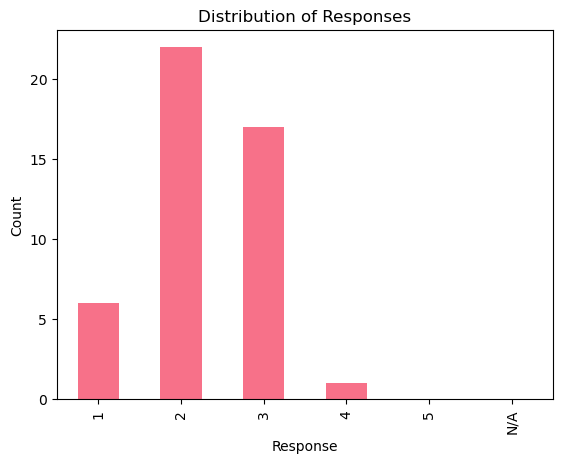

In [ ]:

df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

In [25]:
# compute the average and std scores
average_score = df["response"].replace("N/A", pd.NA).astype(float).mean()
std_score = df["response"].replace("N/A", pd.NA).astype(float).std()
print(f"Average score: {average_score:.2f}")
print(f"Standard deviation of scores: {std_score:.2f}")

Average score: 2.28
Standard deviation of scores: 0.72


In [26]:
is_there_a_good_market(df)

Percentage of positive responses (4-5): 2.17%
Percentage of neutral responses (3): 36.96%
Percentage of negative responses (1-2): 60.87%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.28
Standard deviation of responses: 0.72
VERDICT: There is not a good market for bottled gazpacho.


False

We can also chat with the agents in an ad-hoc way, to get a more detailed understanding if needed.

In [27]:
from tinytroupe.ui import AgentChatJupyterWidget

# Create and display the enhanced chat widget
chat_interface = AgentChatJupyterWidget(people)
chat_interface.display()

In [28]:
control.end()

## Empirical Data Validation
Now let's see how the above matches the same research done with actual real people!

In [29]:
control_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_csv(
            file_path="../data/empirical/07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv",
            experimental_data_type="single_value_per_agent",
            agent_id_column="Responder #",
            value_column="Vote",
            agent_comments_column="Explanation",
            agent_attributes_columns=["Age Range", "Gender Identity", "Political Affiliation", "Racial Or Ethnic Identity"],
            dataset_name="Test Gazpacho Survey"
        )

In [30]:
control_data

SimulationExperimentDataset(name='Test Gazpacho Survey', description='Empirical data loaded from 07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv', key_results={'Vote': [4, 1, 1, 5, 3, 4, 2, 4, 1, 1, 3, 2, 2, 5, 4, 3, 3, 5, 4, 2, 3, 5, 3, 3, 5, 1, 3, 4, 3, 1, 1, 4, 3, 3, 2, 1, 4, 3, 4, 2, 1, 1, 2, 1, 2, 5, 2, 4, 3, 5]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 5, 'num_ranks': 5, 'rank_values': [1, 2, 3, 4, 5], 'direction': 'ascending'}}, agent_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'], agent_justifications=[{'agent_name': '1', 'agent_index': 0, 'justification': 'Yes because it is something i have nev

<Axes: xlabel='0'>

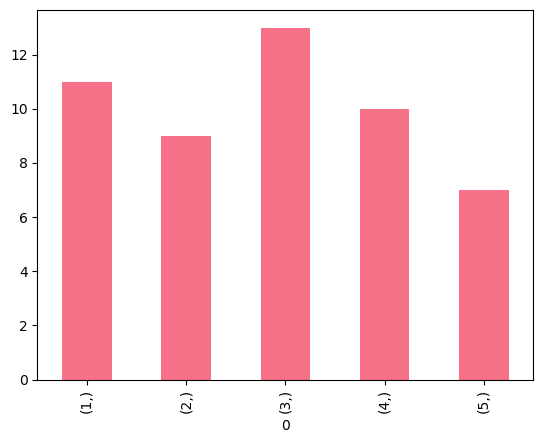

In [50]:
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind="bar")

In [31]:
# Convert string responses to numeric values and rename column to match control_data
df_for_validation = df.copy()
df_for_validation["Vote"] = pd.to_numeric(df_for_validation["response"], errors='coerce')

# Create treatment data with matching column name and data type
treatment_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_dataframe(
    df=df_for_validation,
    experimental_data_type="single_value_per_agent",
    agent_id_column="name",
    value_column="Vote",
    agent_comments_column="justification",
    dataset_name="Bottled Gazpacho Simulation Results"
)

In [32]:
treatment_data

SimulationExperimentDataset(name='Bottled Gazpacho Simulation Results', description='Empirical data loaded from pandas DataFrame', key_results={'Vote': [3, 3, 2, 1, 2, 2, 3, 2, 1, 3, 3, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 1, 3, 4, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 1, 3, 2, 2, 3, 1, 3, 2, 3, 3, 2, 2]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 4, 'num_ranks': 4, 'rank_values': [1, 2, 3, 4], 'direction': 'ascending'}}, agent_names=['Calvin Theodore Ashford', 'Mateo Alejandro Vargas Herrera', 'Ethan Marshall Granger', 'Clarence Darnell Whitfield', 'Clara Meredith Hargrove', 'Loretta Janice Freeman', 'Isabel Mariela Torres Delgado', 'Mabel Louise Cartwright', 'Wesley Grant Carmichael', 'Jordan Kai Navarro-Simms', 'Evelyn Margaret Hensley', 'Gideon Marshall Treadwell', 'Isabel Cristina Mendoza Rivera', 'Thomas Red Elk', 'Mildred Joyce Hargis', 'Nalani Kealoha Makoa', 'Caroline Mer

In [33]:
result_ttest = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        output_format="values"
    )

In [34]:
result_ttest.overall_score

0.6553885257528609

In [35]:
result_ttest.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Welch t-test (unequal variance)',
    'control_mean': 2.86,
    'treatment_mean': 2.282608695652174,
    'mean_difference': -0.577391304347826,
    'percent_change': -20.188507145028883,
    't_statistic': 2.635103087825971,
    'p_value': 0.010192536170239803,
    'confidence_interval': (-1.0138072461753547, -0.14097536252029735),
    'confidence_level': 0.95,
    'significant': True,
    'degrees_of_freedom': 75.89165655974334,
    'control_sample_size': 50,
    'treatment_sample_size': 46,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.7199704771188229,
    'effect_size': -0.5258124924467901}}},
 'test_type': 'welch_t_test',
 'significance_level': 0.05}

In [36]:
result_ttest.semantic_results

In [37]:
result_ks = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        statistical_test_type="ks_test",
        output_format="values"
    )

In [38]:
result_ks.overall_score

0.758575197889182

In [39]:
result_ks.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Kolmogorov-Smirnov test',
    'control_mean': 2.86,
    'treatment_mean': 2.282608695652174,
    'control_median': 3.0,
    'treatment_median': 2.0,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.7199704771188229,
    'ks_statistic': 0.3182608695652174,
    'p_value': 0.011364552883959078,
    'significant': True,
    'control_sample_size': 50,
    'treatment_sample_size': 46,
    'effect_size': 0.3182608695652174,
    'overlap_coefficient': 0.42063001852995663,
    'percentile_differences': {'p25_diff': 0.0,
     'p50_diff': -1.0,
     'p75_diff': -1.0,
     'p90_diff': -2.0,
     'p95_diff': -2.0},
    'interpretation': 'Moderate difference between distributions',
    'confidence_level': 0.95}}},
 'test_type': 'ks_test',
 'significance_level': 0.05}

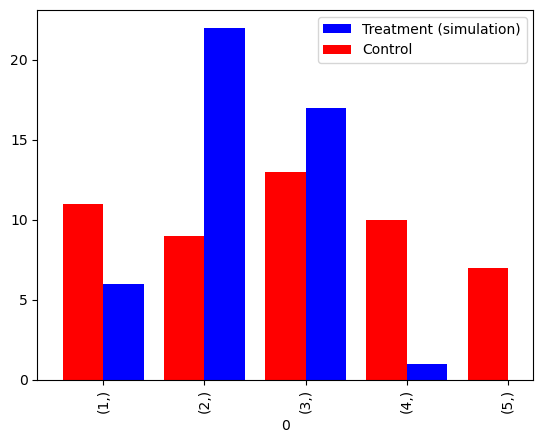

In [53]:
# compare charts. Put both bars in the same plot, for easier comparison
# Need to order the labels in the chart.
fig, ax = plt.subplots()
df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar', color='blue', position=0, width=0.4, label="Treatment (simulation)", ax=ax)
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind='bar', color='red', position=1, width=0.4, label="Control", ax=ax)
plt.legend()
plt.show()